### <img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-393/578 Máquinas de Aprendizaje - 2019-1 </h1>

<H3 align='center'> Tarea 3 - Parte3  </H3>
<hr style="height:2px;border:none"/>

**Integrantes**  
* Rodrigo Hermosilla
* Eliana Providel
* Sebastián Rodriguez

<a id="tercero"></a>
## 3. Clasificación en texto

Un problema muy complejo, en el cual actualmente se esta avanzando a pasos de gigantes en comparación con los avances de hace unos cuantos años, es en la comprehensión de texto, o de lenguaje natural en general. Nuestra manera de construir significado a partir de las palabras es mucho más compleja de lo que nos damos cuenta y supone un gran grado de conocimiento previo que hemos adquirido a lo largo de nuestras vidas. Lograr que una maquina de aprendizaje pueda extraer significado o interpretaciones a partir de un texto es un problema bastante actual, en el cual aún se hacen avances día a día. En esta pregunta utilizaremos una base de datos de texto, extraida de _reviews_ de peliculas en la página IMDB. Cada uno de estos _reviews_ esta etiquetado como positivo o negativo. Nuestra tarea será predecir esta etiqueta a partir de la secuencia de palabras encodeadas como frecuencias de cada ejemplo.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/6a/New-imdb-logo.png/1024px-New-imdb-logo.png"  style="height:6cm;"  />

Para esto probaremos distintas técnicas, incluyendo Perceptron, Redes densas _feed forward_ y ensamblados. Si bien ninguna de estas aproximaciones son las usualmente utilizadas en la actualidad para procesamiento de texto (_words embeddings_, redes recurrentes y redes convolucionales, entre muchos otros), esta pregunta servirá como una buena aproximación a las problematicas usualmente encontradas en estas técnicas y al momento de trabajar con texto. 


#### 3.a Carga de datos

> Cargue los datos. Utilizaremos 45000 de los datos como entrenamiento y el resto como validación. Guarde los datos originales luego del _padding_ en un _array_ que utilizaremos más adelante, y cree otro _array_ 2-dimensional con los datos como categorías binarias como muestran las últimas lineas de código.

> Lea un poco de la documentación de keras y comente sobre los parámetros utilizados al momento de cargar los datos. ¿Qué realiza la función `pad_sequences`? Comente también sobre sus parámetros.


In [1]:
import numpy as np
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from keras.callbacks import LambdaCallback
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import  confusion_matrix, classification_report
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
%matplotlib inline

/home/srodriguez/miniconda/envs/jupyterhub/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
num_words=100
(x_tr_o, y_tr), (x_val_o, y_val) = imdb.load_data(num_words=num_words,
                                             skip_top=10,
                                             oov_char=0,
                                             )

In [3]:
#mostramos largos de secuencias originales
_=[print(len(x_tr_o[i])) for i in range(10)]

218
189
141
550
147
43
123
562
233
130


> Paso de los datos a largos estandarizados de 100 elementos

El pad_sequences rellena de 0 los elementos, para dejarlos todos de un mismo largo.

Parámetros:
- El primero (data) es la secuencia o sobre la cual se aplicará el padding.
- El segundo (maxlen), indica el tamaño maximo de la secuencia de salida.
- El tercero (padding), indica que el padding (llenado) se hará al final de la secuencia.
- El cuarto (truncating), indica donde se hará el corte para secuencias de origen de largo mayor al maxlen definido.
- El quinto (value), el valor que se agregará en el padding.

In [4]:
x_tr_o = pad_sequences(x_tr_o, maxlen=100, padding='post', truncating='post',value=0)
x_val_o = pad_sequences(x_val_o, maxlen=100, padding='post', truncating='post',value=0)

In [5]:
#verificamos los nuevos largos de secuencia
_=[print(len(x_tr_o[i])) for i in range(10)]

100
100
100
100
100
100
100
100
100
100


In [6]:
print(len(x_tr_o))
print(len(x_val_o))

25000
25000


In [7]:
#resize de los set de datos
x_tr_o = np.append(x_tr_o, x_val_o[:20000,],axis=0)
y_tr = np.append(y_tr, y_val[:20000,],axis=0)
x_val_o=x_val_o[20000:]
y_val=y_val[20000:]

In [8]:
print(len(x_tr_o))
print(len(x_val_o))

45000
5000


In [9]:
x_tr_o

array([[ 0, 14, 22, ...,  0,  0, 16],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0, 14, 47, ...,  0, 23,  0],
       ...,
       [ 0,  0,  0, ..., 11, 31, 42],
       [ 0, 14,  0, ...,  0,  0,  0],
       [ 0, 14,  0, ...,  0,  0,  0]], dtype=int32)

In [12]:
x_tr = to_categorical(x_tr_o, num_classes=101).reshape(x_tr_o.shape[0],x_tr_o.shape[1],-1)
x_val = to_categorical(x_val_o, num_classes=101).reshape(x_val_o.shape[0],-1)

In [13]:
x_tr.shape

(45000, 100, 101)

#### 3.b Perceptrón **(Opcional)**
> Entrene un perceptrón con activación sigmoidea, optimizador _Stochastic Gradient Descent_, por a lo menos 15 _epochs_, como muestra el código siguiente. 

> Discuta sobre la dimensión de `x_tr` y la cantidad de parámetros del modelo deacuerdo al método `.summary` del modelo. 

> Grafique el error o el _accuracy_ segun su preferencia, tanto sobre entrenamiento como validación, a medida pasan los _epochs_. Note esta información puede obtenerla desde `history.history`.

In [11]:
from keras import backend as K
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

In [17]:
model3b = Sequential()
model3b.add(Dense(1,activation='sigmoid'))
model3b.compile('sgd',loss='binary_crossentropy',metrics=['accuracy'])
history3b = model3b.fit(x_tr,y_tr, epochs=100, validation_data=(x_val,y_val),verbose=3)

model3b.summary()

Train on 45000 samples, validate on 5000 samples
Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/10

In [21]:
def plotCM(y_val, y_pred, title):
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(15,6))
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix: '+title) 
    _=plt.show()

In [22]:
def showValAcc(history):
    fig=plt.figure(figsize=(15,10))
    ax1 = fig.add_subplot(2, 1, 1)
    ax1.set_title('loss vs val_loss')
    ax1.plot(history.history['loss'], label='Train loss')
    ax1.plot(history.history['val_loss'], label='Validation loss')
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()
    ax2 = fig.add_subplot(2, 1, 2)
    ax2.set_title('acc vs val_acc')
    ax2.plot(history.history['acc'], label='Train accuracy')
    ax2.plot(history.history['val_acc'], label='Validation accuracy')
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.legend()
    _=plt.show()

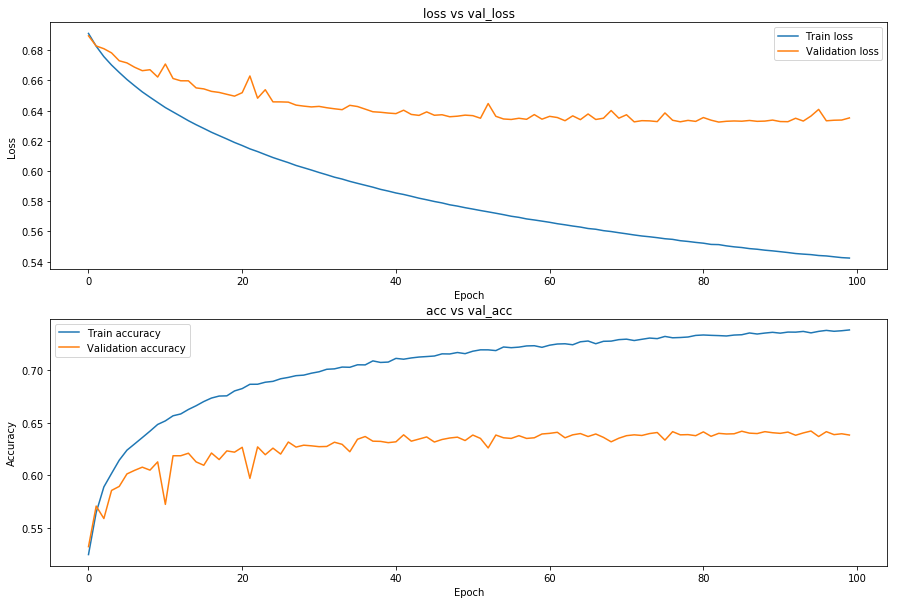

In [23]:
showValAcc(history3b)

**Comentarios:** podemos observar que es mejor que "tirar una moneda", pero nuestro modelo se ajusta demasiado a los datos de entrenamiento (sobreajuste), obteniendo menos poder de generalización. Esto se puede observar en los graficos, donde la exactitud aumenta para el conjunto de entrenamiento, mientras que para el conjunto de validación queda estancado entre 0.60 y 0.65. 

> Discuta sobre la dimensión de `x_tr` y la cantidad de parámetros del modelo deacuerdo al método `.summary` del modelo. 

respecto a a dimension de los datos (x_tr y x_val), podemos observar que cada muestra fue transformada a un tamaño de 10100 elementos, donde estos van de 100 en 100 presentando la secuencia en forma binaria dada la presencia de una "palabra" (el identificador numerico asociado a la palabra). Dado esto, el modelo del perceptron va a tener 10101 parametros a entrenara (los pesos para cada una de los casilleros de las features, mas el intercepto).

#### 3.c Red con una capa oculta
>Ahora, haremos nuevamente un modelo secuencial, al cual le agregarémos una capa oculta con activación ReLu. ¿Qué realiza la función ReLu (puede ejemplificar con gráficos)?

>Entrene esta red nuevamente con los mismos parámetros que la red anterior. ¿Mejoran los desempeños? ¿Cuál es el número de parámetros de este modelo? Grafíque nuevamente como varía la métrica a medida pasan las _epochs_. ¿Alcanza a notar sobreajuste?

>Cambie la función de activación por otra de su elección (e.g. $tanh$ o activación lineal). ¿Cambia el desempeño? 

>Compare finalmente el desempeño con una regresión lineal. ¿Cómo hace la red para obtener representaciones no-lineales que la regresión lineal no puede obtener? ¿Por qué se podría argumentar que una red neuronal densa _feed forward_ tiene un sabor a ensamblado de regresiones lineales en un principio? 

#### Utilizando RELU

In [24]:
model3c_relu = Sequential()
model3c_relu.add(Dense(32, activation='relu', input_dim=x_tr.shape[1]))
model3c_relu.add(Dense(1,activation='sigmoid'))
model3c_relu.compile('sgd',loss='binary_crossentropy',metrics=['accuracy'])
history3c_relu = model3c_relu.fit(x_tr,y_tr, epochs=50, validation_data=(x_val,y_val))
model3c_relu.summary()

Train on 45000 samples, validate on 5000 samples
Epoch 1/50
45000/45000 [==============================] - 7s 161us/step - loss: 0.6911 - acc: 0.5255 - val_loss: 0.6889 - val_acc: 0.5328
Epoch 2/50
45000/45000 [==============================] - 7s 160us/step - loss: 0.6840 - acc: 0.5584 - val_loss: 0.6832 - val_acc: 0.5636
Epoch 3/50
45000/45000 [==============================] - 7s 158us/step - loss: 0.6762 - acc: 0.5814 - val_loss: 0.6841 - val_acc: 0.5512
Epoch 4/50
45000/45000 [==============================] - 7s 155us/step - loss: 0.6668 - acc: 0.6029 - val_loss: 0.6738 - val_acc: 0.5794
Epoch 5/50
45000/45000 [==============================] - 7s 159us/step - loss: 0.6562 - acc: 0.6191 - val_loss: 0.6784 - val_acc: 0.5652
Epoch 6/50
45000/45000 [==============================] - 7s 156us/step - loss: 0.6447 - acc: 0.6357 - val_loss: 0.6569 - val_acc: 0.6152
Epoch 7/50
45000/45000 [==============================] - 7s 154us/step - loss: 0.6330 - acc: 0.6487 - val_loss: 0.6527 - v

**¿Qué realiza la función ReLu (puede ejemplificar con gráficos)?**

La función RELU lleva todos los valores negativos a cero, conserva el valor de los positivos.

![](relu.png)

> Entrene esta red nuevamente con los mismos parámetros que la red anterior. ¿Mejoran los desempeños? ¿Cuál es el número de parámetros de este modelo? Grafíque nuevamente como varía la métrica a medida pasan las _epochs_. ¿Alcanza a notar sobreajuste?

No mejoran substancialmente el desempeño (haremos una comparación más adelante), y si se puede observar el sobre ajuste en los valores de val_loss

Respecto al numero de parametros del modelo, esto aumentan en total a 323.265 (debido a que son 32 veces las entradas del modelo + los interceptos y pesos para la capa de salida)

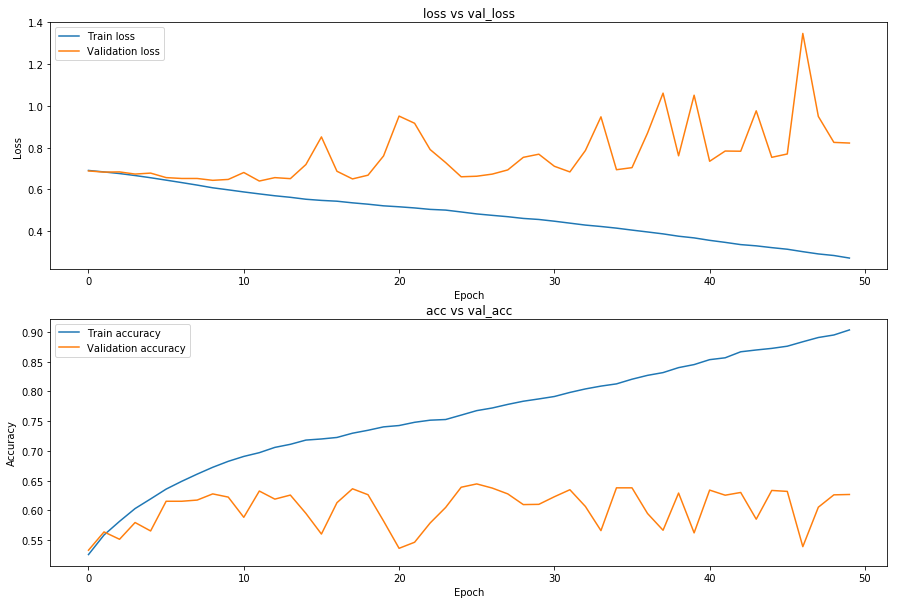

In [30]:
showValAcc(history3c_relu)

>Cambie la función de activación por otra de su elección (e.g. $tanh$ o activación lineal). ¿Cambia el desempeño? 

Aquí ocuparemos tanto la tangente hiperbolica y la activacion lineal. El desempeño del modelo no varia con respecto a relu, provocandose tambien sobreajuste.


#### Utilizando TANH

In [26]:
model3c_tanh = Sequential()
model3c_tanh.add(Dense(32, activation='tanh', input_dim=x_tr.shape[1]))
model3c_tanh.add(Dense(1,activation='sigmoid'))
model3c_tanh.compile('sgd',loss='binary_crossentropy',metrics=['accuracy'])
history3c_tanh = model3c_tanh.fit(x_tr,y_tr, epochs=50, validation_data=(x_val,y_val))
model3c_tanh.summary()

Train on 45000 samples, validate on 5000 samples
Epoch 1/50
45000/45000 [==============================] - 7s 161us/step - loss: 0.6917 - acc: 0.5261 - val_loss: 0.6852 - val_acc: 0.5592
Epoch 2/50
45000/45000 [==============================] - 7s 163us/step - loss: 0.6811 - acc: 0.5682 - val_loss: 0.6808 - val_acc: 0.5608
Epoch 3/50
45000/45000 [==============================] - 7s 155us/step - loss: 0.6716 - acc: 0.5930 - val_loss: 0.6727 - val_acc: 0.5884
Epoch 4/50
45000/45000 [==============================] - 7s 159us/step - loss: 0.6625 - acc: 0.6088 - val_loss: 0.6668 - val_acc: 0.5934
Epoch 5/50
45000/45000 [==============================] - 7s 159us/step - loss: 0.6517 - acc: 0.6265 - val_loss: 0.6941 - val_acc: 0.5254
Epoch 6/50
45000/45000 [==============================] - 7s 158us/step - loss: 0.6400 - acc: 0.6390 - val_loss: 0.6556 - val_acc: 0.6222
Epoch 7/50
45000/45000 [==============================] - 7s 156us/step - loss: 0.6287 - acc: 0.6507 - val_loss: 0.7805 - v

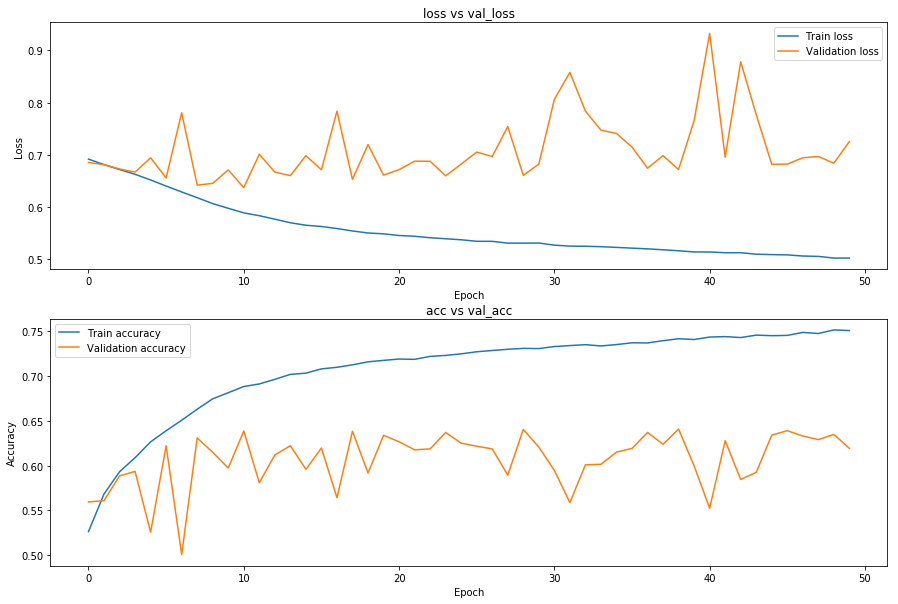

In [27]:
showValAcc(history3c_tanh)

#### Utilizando LINEAR

In [28]:
model3c_linear = Sequential()
model3c_linear.add(Dense(32, activation='linear', input_dim=x_tr.shape[1]))
model3c_linear.add(Dense(1,activation='sigmoid'))
model3c_linear.compile('sgd',loss='binary_crossentropy',metrics=['accuracy'])
history3c_linear =model3c_linear.fit(x_tr,y_tr, epochs=50, validation_data=(x_val,y_val))
model3c_linear.summary()

Train on 45000 samples, validate on 5000 samples
Epoch 1/50
45000/45000 [==============================] - 7s 161us/step - loss: 0.6913 - acc: 0.5287 - val_loss: 0.6845 - val_acc: 0.5634
Epoch 2/50
45000/45000 [==============================] - 7s 162us/step - loss: 0.6764 - acc: 0.5772 - val_loss: 0.6765 - val_acc: 0.5814
Epoch 3/50
45000/45000 [==============================] - 7s 158us/step - loss: 0.6637 - acc: 0.6016 - val_loss: 0.6983 - val_acc: 0.5144
Epoch 4/50
45000/45000 [==============================] - 7s 156us/step - loss: 0.6524 - acc: 0.6242 - val_loss: 0.6628 - val_acc: 0.6048
Epoch 5/50
45000/45000 [==============================] - 7s 160us/step - loss: 0.6406 - acc: 0.6395 - val_loss: 0.7162 - val_acc: 0.5418
Epoch 6/50
45000/45000 [==============================] - 7s 155us/step - loss: 0.6291 - acc: 0.6518 - val_loss: 0.6504 - val_acc: 0.6130
Epoch 7/50
45000/45000 [==============================] - 7s 156us/step - loss: 0.6170 - acc: 0.6641 - val_loss: 0.6444 - v

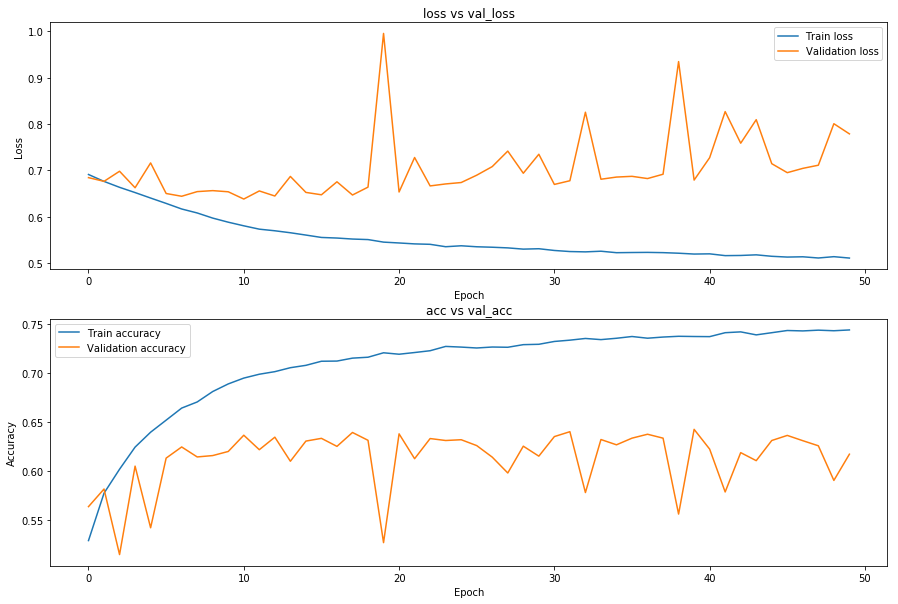

In [29]:
showValAcc(history3c_linear)

In [45]:
print("perceptron: min {}, max {}".format(min(history3b.history['val_acc']),max(history3b.history['val_acc'])))
print("relu: min {}, max {}".format(min(history3c_relu.history['val_acc']),max(history3c_relu.history['val_acc'])))
print("tanh: min {}, max {}".format(min(history3c_tanh.history['val_acc']),max(history3c_tanh.history['val_acc'])))
print("linear: min {}, max {}".format(min(history3c_linear.history['val_acc']),max(history3c_linear.history['val_acc'])))

perceptron: min 0.5326, max 0.642
relu: min 0.5328, max 0.6444
tanh: min 0.5004, max 0.6408
linear: min 0.5144, max 0.6424


**Comparación con distintas funciones de activación**

- Podemos observar que a partir del epoch 5 a 10, que el sobreajuste es un problema para todas las funciones de activación. Mas aun, podemos observar que esto ocurre independiente de la función de activación, por lo que podemos suponer que enfrentar este problema solo con la función de activación, puede que no sea suficiente. Esto indicaria que tenemos que cambiar la topologia de nuestra red (Agregar mas capas),Obtener mas datos, o en su defecto realizar un mejor preprocesamiento de los datos. 

>Cambie la función de activación por otra de su elección (e.g. 𝑡𝑎𝑛ℎ o activación lineal). ¿Cambia el desempeño? 

Luego, como se observan en los valores minimos y maximos de validation accuracy, podemos ver que el rendimiento es similar para todas las distintas funciones de activacion. Aparte de esto, el perceptron siendo una representacion mucho mas parsimoniosa que las redes con una capa oculta, se ajusta de similar manera.



#### Regresión Lineal

In [46]:
reg=LinearRegression()

>Compare finalmente el desempeño con una regresión lineal. 

Podemos observar que la regresion lineal, si bien en terminos de accuracy obtiene un 0.61, las otras metricas asociadas a la matriz de confusion, estan mas balanceadas. La regresion en este caso, tiene aproximadamente la misma cantida de valores falsos postivos y falsos negativos. 

Con respecto a los otros modelos de redes neuronales, estos se sesgan mas hacia una de las etiquetas (mas falsos negativos en el caso de la tanh y activacion lineal, o mas falsos positivos en el caso de relu)

In [47]:
reg.fit(x_tr, y_tr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

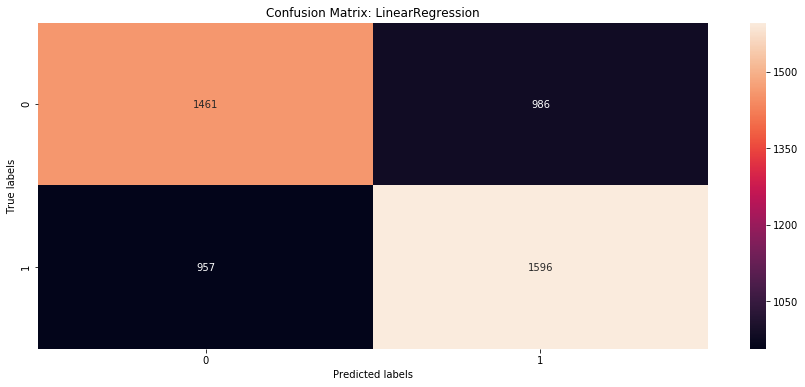

              precision    recall  f1-score   support

           0       0.60      0.60      0.60      2447
           1       0.62      0.63      0.62      2553

    accuracy                           0.61      5000
   macro avg       0.61      0.61      0.61      5000
weighted avg       0.61      0.61      0.61      5000



In [48]:
y_pred=reg.predict(x_val)
y_pred_binary = np.where(y_pred>0.5, 1,0)
plotCM(y_val, y_pred_binary, 'LinearRegression')
print(classification_report(y_val, y_pred_binary))

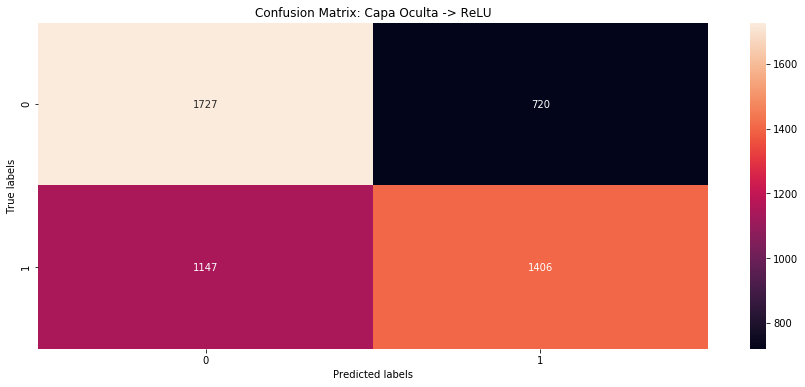

              precision    recall  f1-score   support

           0       0.60      0.71      0.65      2447
           1       0.66      0.55      0.60      2553

    accuracy                           0.63      5000
   macro avg       0.63      0.63      0.63      5000
weighted avg       0.63      0.63      0.62      5000



In [49]:
y_pred=model3c_relu.predict(x_val)
y_pred_binary = np.where(y_pred>0.5, 1,0)
plotCM(y_val, y_pred_binary, 'Capa Oculta -> ReLU')
print(classification_report(y_val, y_pred_binary))

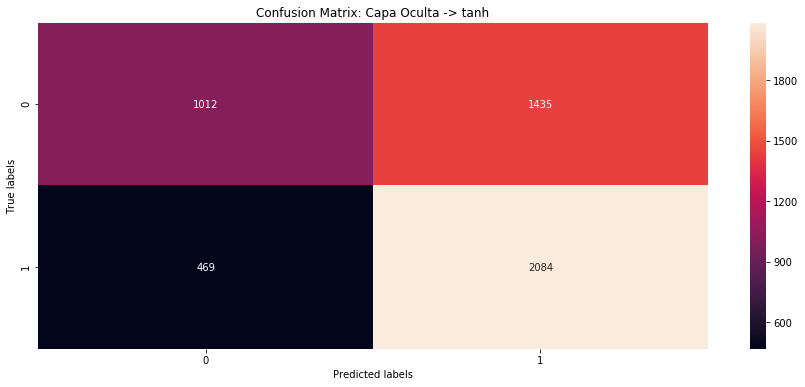

              precision    recall  f1-score   support

           0       0.68      0.41      0.52      2447
           1       0.59      0.82      0.69      2553

    accuracy                           0.62      5000
   macro avg       0.64      0.61      0.60      5000
weighted avg       0.64      0.62      0.60      5000



In [50]:
y_pred=model3c_tanh.predict(x_val)
y_pred_binary = np.where(y_pred>0.5, 1,0)
plotCM(y_val, y_pred_binary, 'Capa Oculta -> tanh')
print(classification_report(y_val, y_pred_binary))

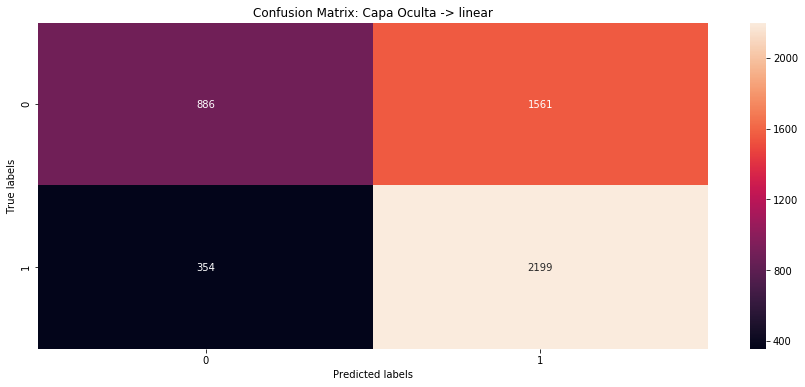

              precision    recall  f1-score   support

           0       0.71      0.36      0.48      2447
           1       0.58      0.86      0.70      2553

    accuracy                           0.62      5000
   macro avg       0.65      0.61      0.59      5000
weighted avg       0.65      0.62      0.59      5000



In [51]:
y_pred=model3c_linear.predict(x_val)
y_pred_binary = np.where(y_pred>0.5, 1,0)
plotCM(y_val, y_pred_binary, 'Capa Oculta -> linear')
print(classification_report(y_val, y_pred_binary))

>¿Cómo hace la red para obtener representaciones no-lineales que la regresión lineal no puede obtener? 

A través de la funcion de activacion, podemos tomar el conjunto de representaciones lineales, y llevarlas a un espacio no lineal.

>¿Por qué se podría argumentar que una red neuronal densa _feed forward_ tiene un sabor a ensamblado de regresiones lineales en un principio?  

Podriamos intentar justificar que una red neuronal feed forward corresponde a un ensamblado de perceptrones con su funcion de activación, apiladas de forma jerarquica. Pero las redes neuronales no corresponden a un ensamblado de perceptrones, principalmente por que un setting ensamblado se entrenaria de forma paralela, mientras que una red neuronal depende de las arquitectura misma para poder realizar un entrenamiento.

#### 3.d Exploración de número de neuronas ocultas

>Utilizando la misma estructura de la red entrenada en la pregunta anterior, evalue como varía el _accuracy_ sobre validación y entrenamiento a medida se cambia el numero de neuronas. Explore numeros de neuronas en potencias de 2 entre 2 y 256. En cada iteración debe considerar el mejor _accuracy_ sobre validación y el _accuracy_ de entrenamiento de ese mísmo _epoch_, pues ese sería el modelo que se preferiría. 

>Grafique como variaron los _accuracy_ a medida cambió el número de neuronas y discuta. 

El modelo con mejor val accuracy corresponde a la red neuronal con 128 nodos en la capa oculta. Obteniendo un 0.6424 de accuracy de validación.

Con respecto al conjunto de entrenamiento, el mejor modelo corresponde a la red neuronal con 256 nodos en la capa oculta.

In [54]:
import gc

Red con 2 unidades
Train on 45000 samples, validate on 5000 samples
Epoch 1/25
45000/45000 [==============================] - 7s 161us/step - loss: 0.6930 - acc: 0.5066 - val_loss: 0.6936 - val_acc: 0.4894
Epoch 2/25
45000/45000 [==============================] - 7s 162us/step - loss: 0.6927 - acc: 0.5150 - val_loss: 0.6928 - val_acc: 0.5150
Epoch 3/25
45000/45000 [==============================] - 7s 159us/step - loss: 0.6921 - acc: 0.5287 - val_loss: 0.6929 - val_acc: 0.5064
Epoch 4/25
45000/45000 [==============================] - 7s 156us/step - loss: 0.6908 - acc: 0.5434 - val_loss: 0.6919 - val_acc: 0.5208
Epoch 5/25
45000/45000 [==============================] - 7s 160us/step - loss: 0.6888 - acc: 0.5601 - val_loss: 0.6896 - val_acc: 0.5534
Epoch 6/25
45000/45000 [==============================] - 7s 160us/step - loss: 0.6855 - acc: 0.5724 - val_loss: 0.6874 - val_acc: 0.5568
Epoch 7/25
45000/45000 [==============================] - 7s 156us/step - loss: 0.6807 - acc: 0.5854 - v

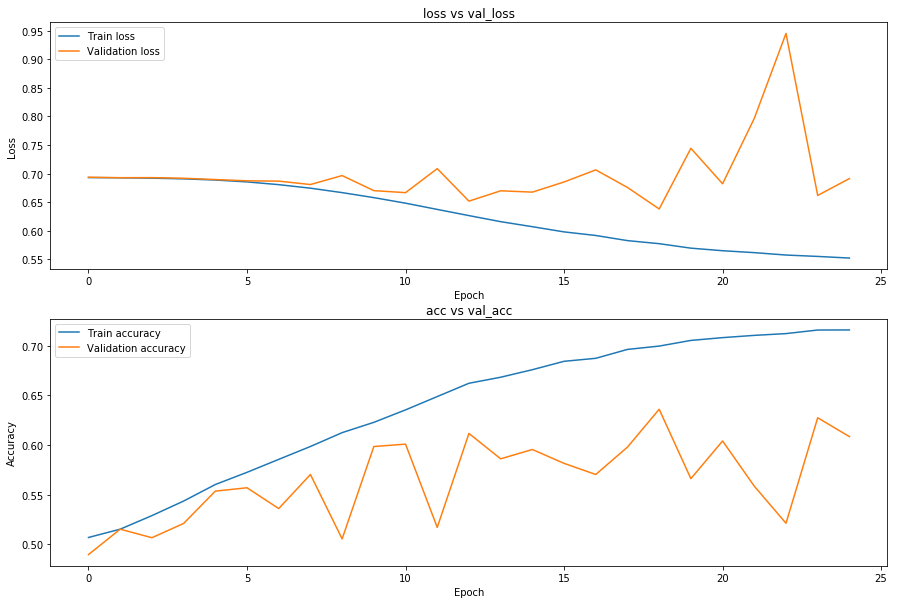

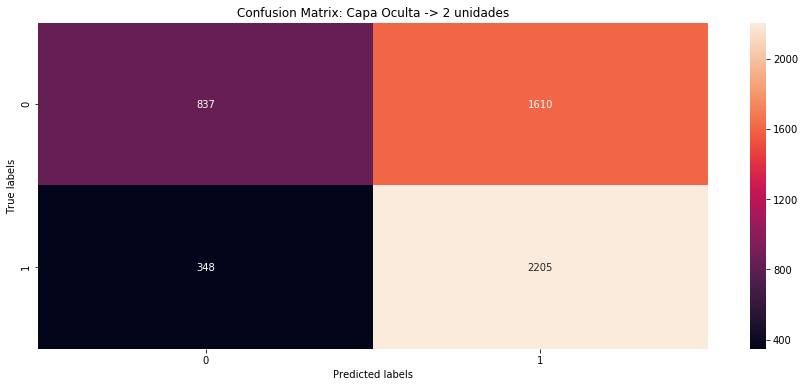

              precision    recall  f1-score   support

           0       0.71      0.34      0.46      2447
           1       0.58      0.86      0.69      2553

    accuracy                           0.61      5000
   macro avg       0.64      0.60      0.58      5000
weighted avg       0.64      0.61      0.58      5000

Red con 4 unidades
Train on 45000 samples, validate on 5000 samples
Epoch 1/25
45000/45000 [==============================] - 7s 160us/step - loss: 0.6933 - acc: 0.4981 - val_loss: 0.6930 - val_acc: 0.5106
Epoch 2/25
45000/45000 [==============================] - 7s 160us/step - loss: 0.6932 - acc: 0.5004 - val_loss: 0.6932 - val_acc: 0.4902
Epoch 3/25
45000/45000 [==============================] - 7s 153us/step - loss: 0.6932 - acc: 0.5029 - val_loss: 0.6931 - val_acc: 0.5106
Epoch 4/25
45000/45000 [==============================] - 7s 157us/step - loss: 0.6932 - acc: 0.4979 - val_loss: 0.6932 - val_acc: 0.4896
Epoch 5/25
45000/45000 [=============================

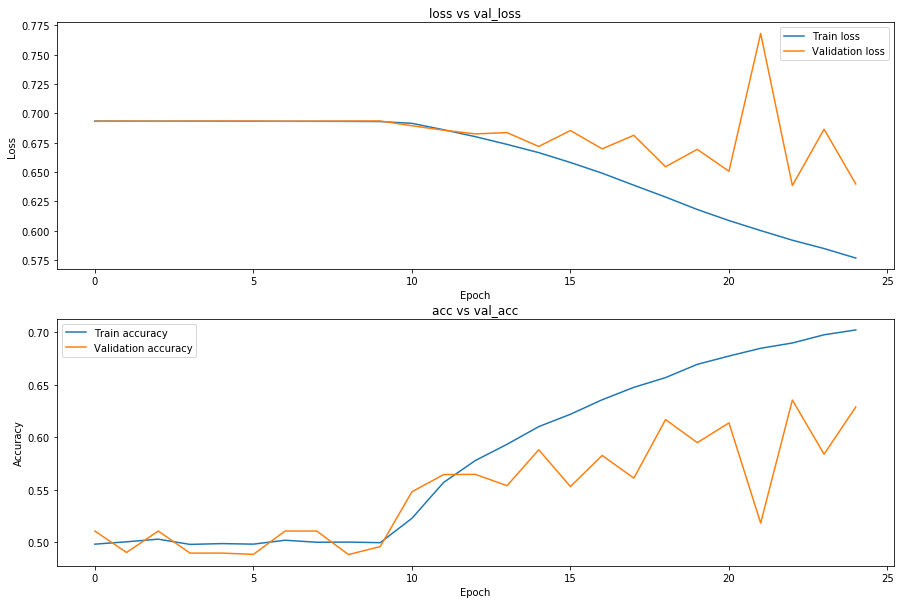

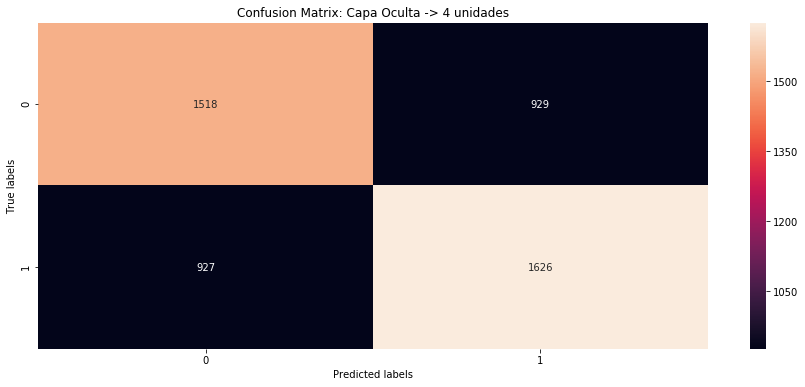

              precision    recall  f1-score   support

           0       0.62      0.62      0.62      2447
           1       0.64      0.64      0.64      2553

    accuracy                           0.63      5000
   macro avg       0.63      0.63      0.63      5000
weighted avg       0.63      0.63      0.63      5000

Red con 8 unidades
Train on 45000 samples, validate on 5000 samples
Epoch 1/25
45000/45000 [==============================] - 7s 159us/step - loss: 0.6924 - acc: 0.5170 - val_loss: 0.6919 - val_acc: 0.5242
Epoch 2/25
45000/45000 [==============================] - 8s 170us/step - loss: 0.6885 - acc: 0.5444 - val_loss: 0.6901 - val_acc: 0.5264
Epoch 3/25
45000/45000 [==============================] - 7s 155us/step - loss: 0.6821 - acc: 0.5698 - val_loss: 0.6868 - val_acc: 0.5448
Epoch 4/25
45000/45000 [==============================] - 7s 157us/step - loss: 0.6738 - acc: 0.5923 - val_loss: 0.6779 - val_acc: 0.5806
Epoch 5/25
45000/45000 [=============================

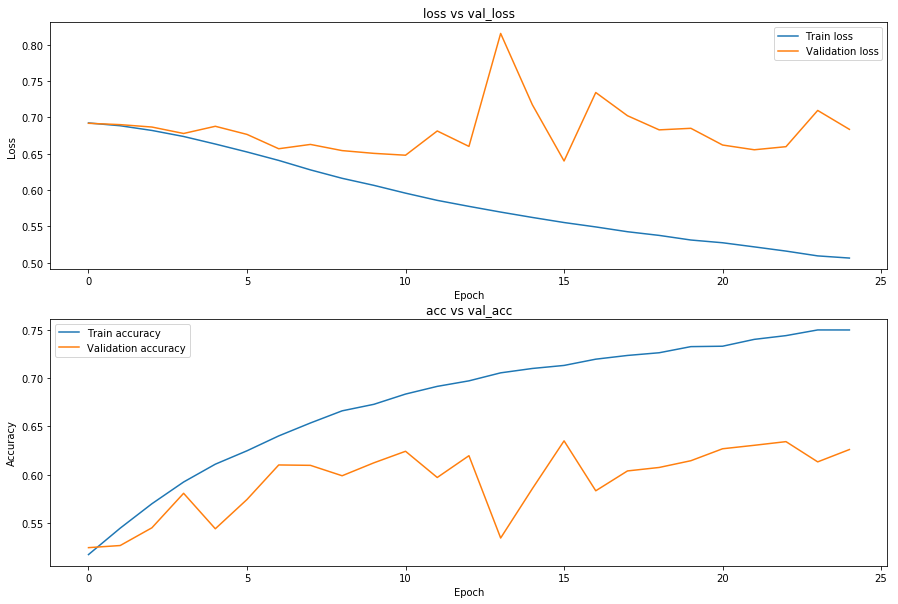

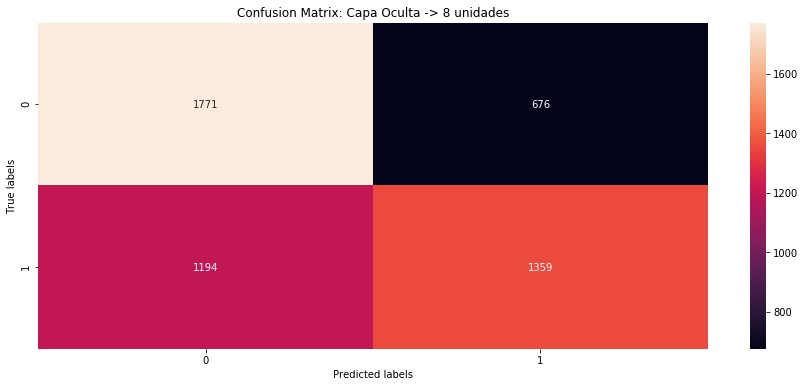

              precision    recall  f1-score   support

           0       0.60      0.72      0.65      2447
           1       0.67      0.53      0.59      2553

    accuracy                           0.63      5000
   macro avg       0.63      0.63      0.62      5000
weighted avg       0.63      0.63      0.62      5000

Red con 16 unidades
Train on 45000 samples, validate on 5000 samples
Epoch 1/25
45000/45000 [==============================] - 7s 157us/step - loss: 0.6916 - acc: 0.5245 - val_loss: 0.6916 - val_acc: 0.5176
Epoch 2/25
45000/45000 [==============================] - 7s 161us/step - loss: 0.6864 - acc: 0.5550 - val_loss: 0.6877 - val_acc: 0.5430
Epoch 3/25
45000/45000 [==============================] - 7s 155us/step - loss: 0.6790 - acc: 0.5781 - val_loss: 0.6809 - val_acc: 0.5702
Epoch 4/25
45000/45000 [==============================] - 7s 157us/step - loss: 0.6704 - acc: 0.5957 - val_loss: 0.6940 - val_acc: 0.5384
Epoch 5/25
45000/45000 [============================

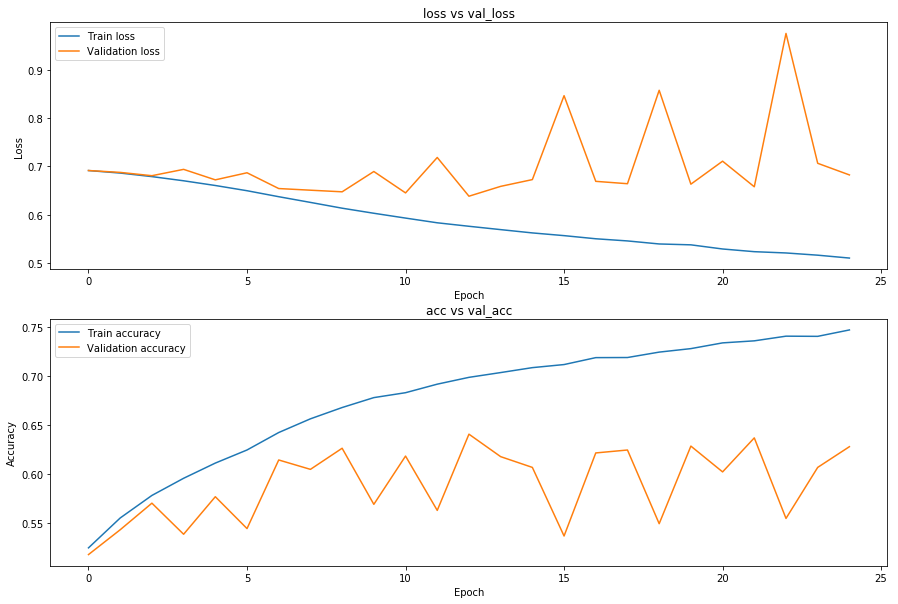

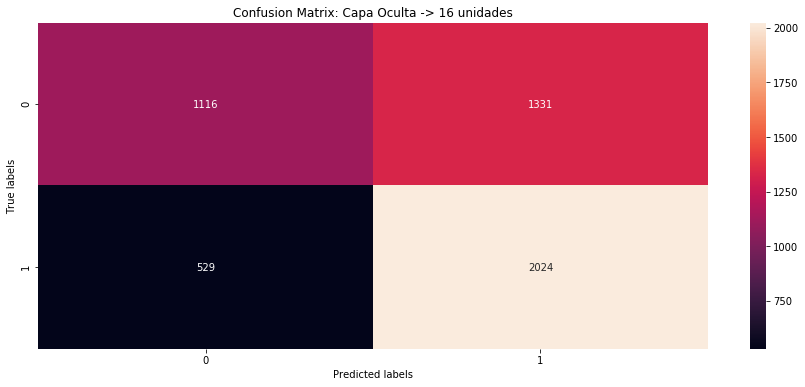

              precision    recall  f1-score   support

           0       0.68      0.46      0.55      2447
           1       0.60      0.79      0.69      2553

    accuracy                           0.63      5000
   macro avg       0.64      0.62      0.62      5000
weighted avg       0.64      0.63      0.62      5000

Red con 32 unidades
Train on 45000 samples, validate on 5000 samples
Epoch 1/25
45000/45000 [==============================] - 7s 166us/step - loss: 0.6909 - acc: 0.5280 - val_loss: 0.6873 - val_acc: 0.5458
Epoch 2/25
45000/45000 [==============================] - 7s 155us/step - loss: 0.6832 - acc: 0.5609 - val_loss: 0.6850 - val_acc: 0.5516
Epoch 3/25
45000/45000 [==============================] - 7s 156us/step - loss: 0.6744 - acc: 0.5873 - val_loss: 0.6769 - val_acc: 0.5778
Epoch 4/25
45000/45000 [==============================] - 7s 160us/step - loss: 0.6643 - acc: 0.6084 - val_loss: 0.6768 - val_acc: 0.5774
Epoch 5/25
45000/45000 [============================

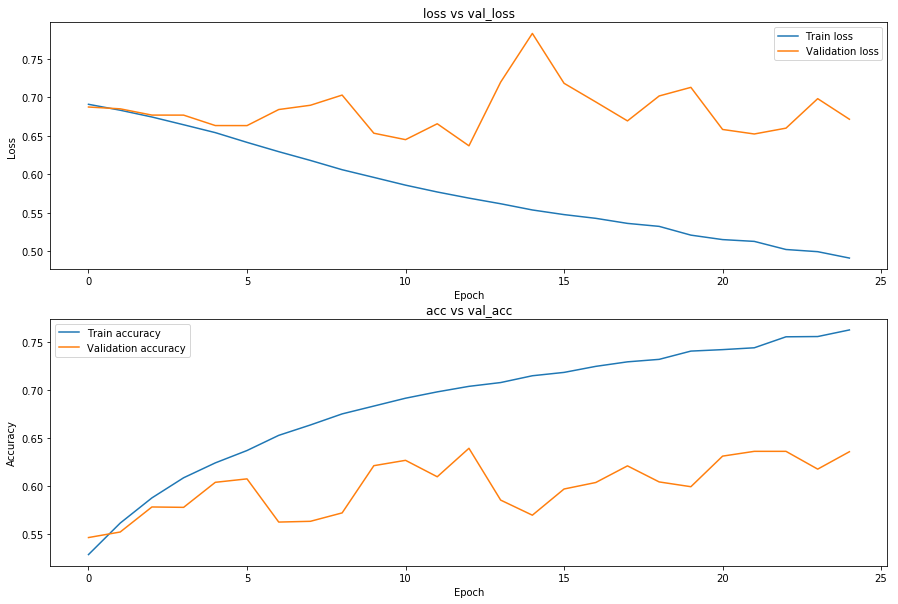

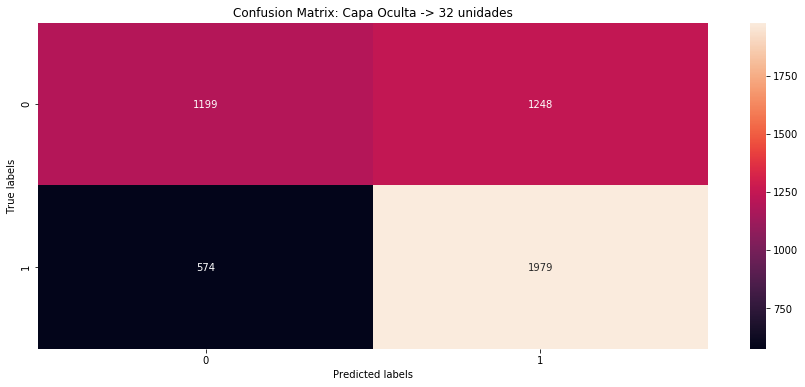

              precision    recall  f1-score   support

           0       0.68      0.49      0.57      2447
           1       0.61      0.78      0.68      2553

    accuracy                           0.64      5000
   macro avg       0.64      0.63      0.63      5000
weighted avg       0.64      0.64      0.63      5000

Red con 64 unidades
Train on 45000 samples, validate on 5000 samples
Epoch 1/25
45000/45000 [==============================] - 8s 167us/step - loss: 0.6917 - acc: 0.5206 - val_loss: 0.6890 - val_acc: 0.5392
Epoch 2/25
45000/45000 [==============================] - 7s 156us/step - loss: 0.6850 - acc: 0.5590 - val_loss: 0.6855 - val_acc: 0.5624
Epoch 3/25
45000/45000 [==============================] - 7s 159us/step - loss: 0.6775 - acc: 0.5794 - val_loss: 0.6798 - val_acc: 0.5698
Epoch 4/25
45000/45000 [==============================] - 7s 161us/step - loss: 0.6687 - acc: 0.5994 - val_loss: 0.6816 - val_acc: 0.5606
Epoch 5/25
45000/45000 [============================

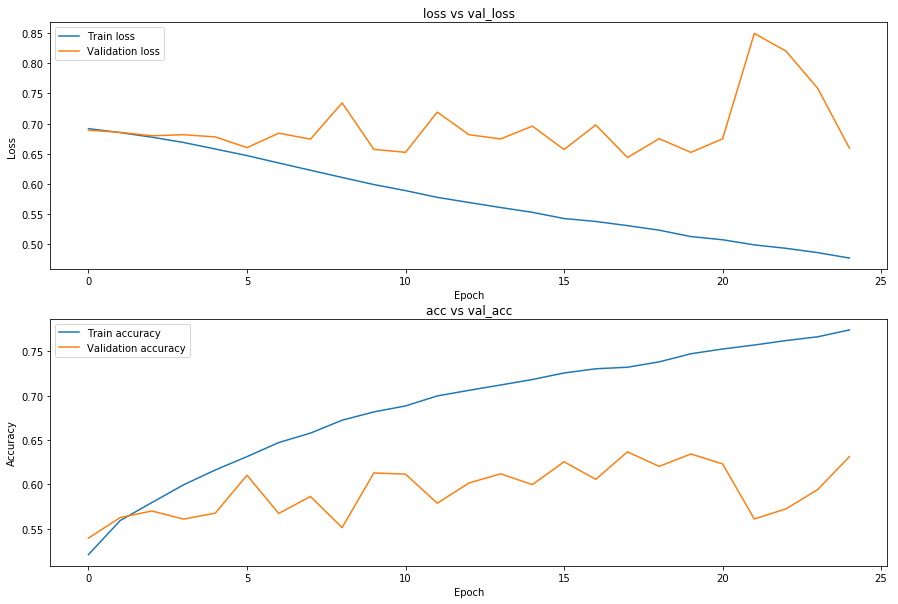

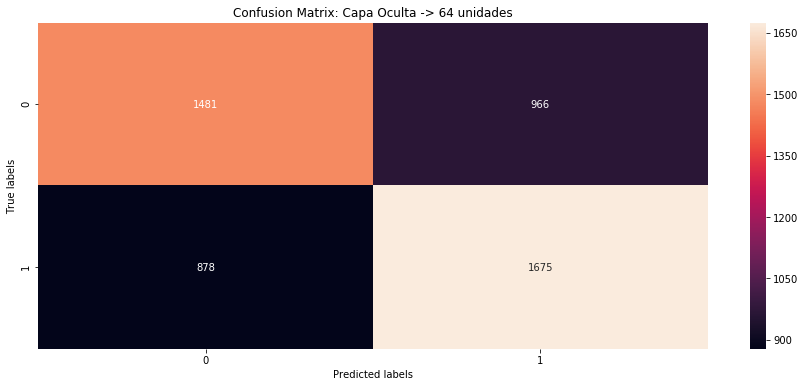

              precision    recall  f1-score   support

           0       0.63      0.61      0.62      2447
           1       0.63      0.66      0.64      2553

    accuracy                           0.63      5000
   macro avg       0.63      0.63      0.63      5000
weighted avg       0.63      0.63      0.63      5000

Red con 128 unidades
Train on 45000 samples, validate on 5000 samples
Epoch 1/25
45000/45000 [==============================] - 8s 168us/step - loss: 0.6912 - acc: 0.5270 - val_loss: 0.6886 - val_acc: 0.5378
Epoch 2/25
45000/45000 [==============================] - 7s 159us/step - loss: 0.6842 - acc: 0.5613 - val_loss: 0.6865 - val_acc: 0.5350
Epoch 3/25
45000/45000 [==============================] - 7s 161us/step - loss: 0.6771 - acc: 0.5806 - val_loss: 0.6806 - val_acc: 0.5752
Epoch 4/25
45000/45000 [==============================] - 7s 163us/step - loss: 0.6688 - acc: 0.5981 - val_loss: 0.6746 - val_acc: 0.5860
Epoch 5/25
45000/45000 [===========================

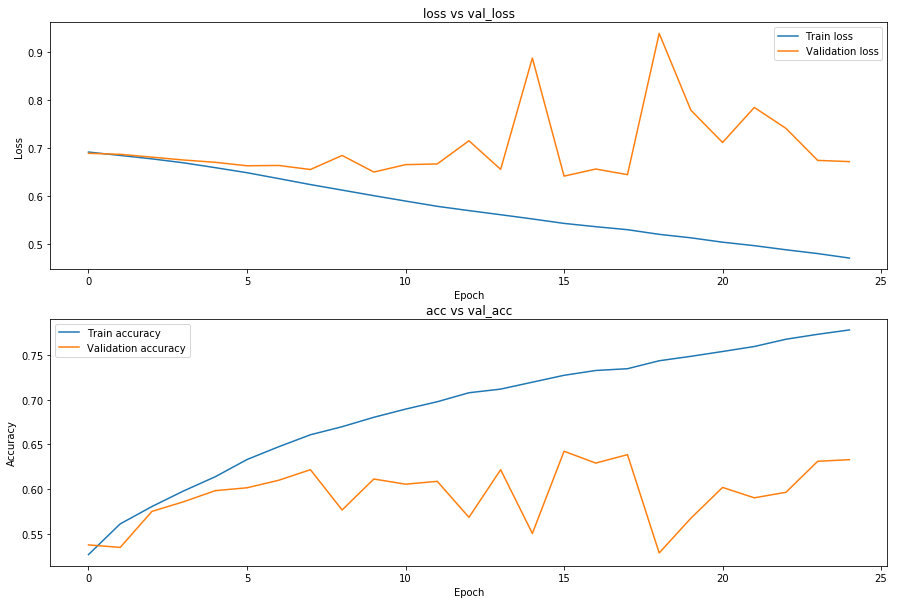

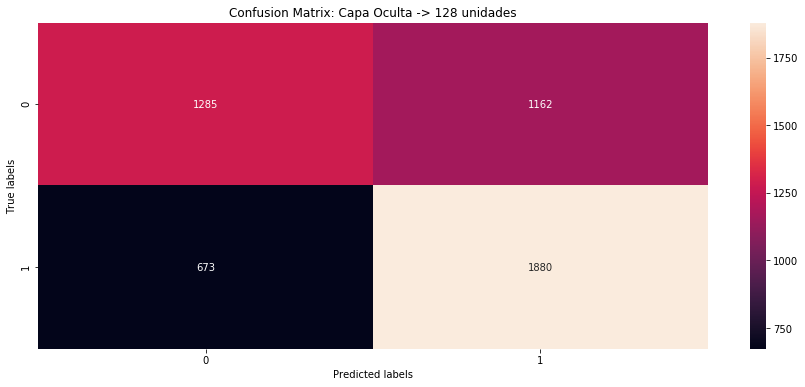

              precision    recall  f1-score   support

           0       0.66      0.53      0.58      2447
           1       0.62      0.74      0.67      2553

    accuracy                           0.63      5000
   macro avg       0.64      0.63      0.63      5000
weighted avg       0.64      0.63      0.63      5000

Red con 256 unidades
Train on 45000 samples, validate on 5000 samples
Epoch 1/25
45000/45000 [==============================] - 9s 197us/step - loss: 0.6905 - acc: 0.5278 - val_loss: 0.6890 - val_acc: 0.5376
Epoch 2/25
45000/45000 [==============================] - 9s 206us/step - loss: 0.6830 - acc: 0.5626 - val_loss: 0.6846 - val_acc: 0.5620
Epoch 3/25
45000/45000 [==============================] - 9s 207us/step - loss: 0.6760 - acc: 0.5858 - val_loss: 0.6800 - val_acc: 0.5788
Epoch 4/25
45000/45000 [==============================] - 9s 200us/step - loss: 0.6678 - acc: 0.5996 - val_loss: 0.6824 - val_acc: 0.5536
Epoch 5/25
45000/45000 [===========================

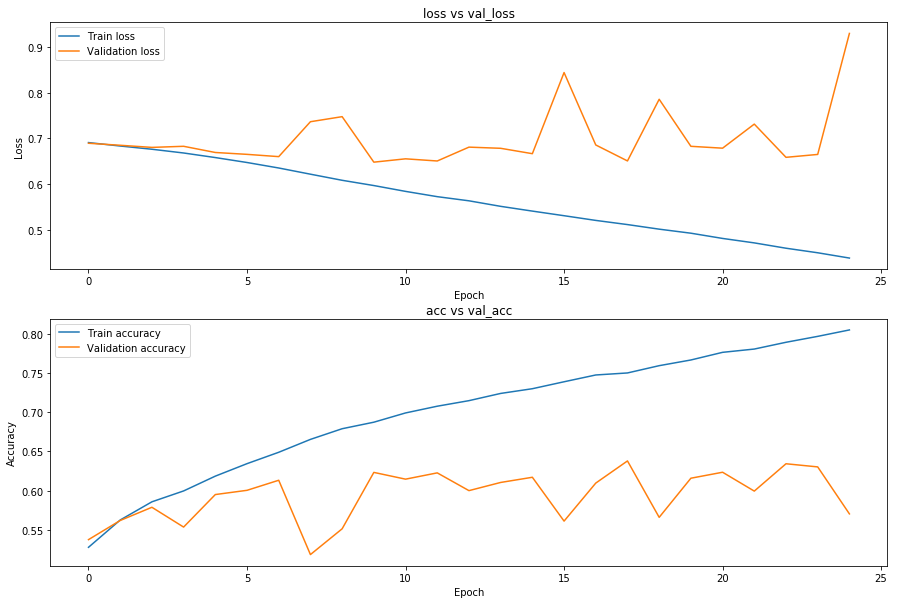

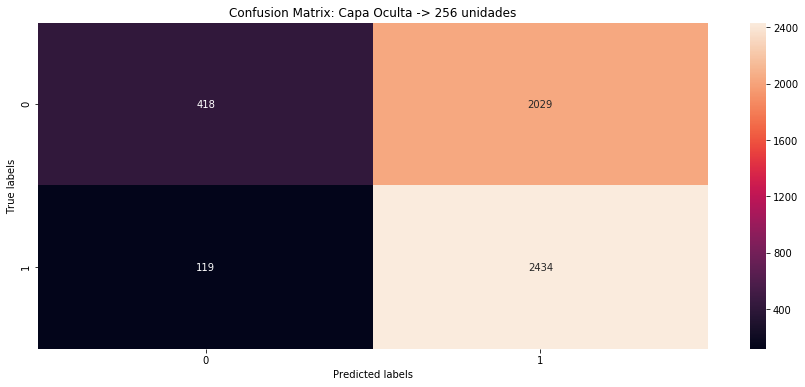

              precision    recall  f1-score   support

           0       0.78      0.17      0.28      2447
           1       0.55      0.95      0.69      2553

    accuracy                           0.57      5000
   macro avg       0.66      0.56      0.49      5000
weighted avg       0.66      0.57      0.49      5000



In [56]:
better_acc=0
better_acc_units=None
better_val_acc=0
better_val_acc_units=None
for i in range(1,9):
    units=2**i
    print('Red con {} unidades'.format(units))
    model3d_relu = Sequential()
    model3d_relu.add(Dense(units=units, activation='relu', input_dim=x_tr.shape[1]))
    model3d_relu.add(Dense(1,activation='sigmoid'))
    model3d_relu.compile('sgd',loss='binary_crossentropy',metrics=['accuracy'])
    history3d_relu = model3d_relu.fit(x_tr,y_tr, epochs=25, validation_data=(x_val,y_val))
    max_acc=np.max(history3d_relu.history['acc'])
    if max_acc>better_acc:
        better_acc=max_acc
        better_acc_units=units
    max_acc_val=np.max(history3d_relu.history['val_acc'])
    if max_acc_val>better_val_acc:
        better_val_acc=max_acc_val
        better_val_acc_units=units
    print('Better accuracy: {} con {} unidades , better validation accuracy: {} con {} unidades'
          .format(better_acc, better_acc_units,better_val_acc,better_val_acc_units))
    showValAcc(history3d_relu)
    y_pred=model3d_relu.predict(x_val)
    y_pred_binary = np.where(y_pred>0.5, 1,0)
    plotCM(y_val, y_pred_binary, 'Capa Oculta -> {} unidades'.format(units))
    print(classification_report(y_val, y_pred_binary))
    
    del model3d_relu
    for _ in range(10):
        gc.collect()
    K.clear_session()

#### 3.e Pesos de la red

Obtenga los pesos de la red entrenada a completitud anteriormente usando el método `.get_weights` y grafíque un historgrama. Note que para cada capa se obtienen por separado los pesos de los datos y del intercepto. Así en el índice 0 obtenemos los pesos de los datos de entrada, en el 1 los pesos del intercepto de entrada, en el 2 los pesos de la capa oculta y en el 3 los pesos del intercepto de la capa oculta. Solo se requiere graficar el primero.

Compare luego ese histograma con el obtenido al graficar los pesos de una red sin entrenar, como muestra el código. Discuta lo que observa. 

**Comentario:**

Lo que podemos observar es que por defecto, keras utiliza un inicializador de pesos por defecto para la capa `Dense` llamado `glorot_uniform`.
`glorot_uniform` toma muestras de una distribución uniforme entre $[-L,L]$, donde:

$$ L = \sqrt{\frac{6}{(fan_{in} + fan_{out})}}$$

donde $fan_{in}$ son la cantidad de unidades de entrada para el tensor de pesos y $fan_{out}$ corresponde a la cantidad de unidades de salida del tensor de peso.

En este caso $L \approx 0.03$ para la red sin entrenar, y conforme al entrenamiento podemos observar que por cada iteración los pesos de los extremos tienen a reducirse, por ende, los pesos de las neuronas empiezan a acercarse mas a cero.

In [229]:
units=128
model3e_relu_untrained = Sequential()
model3e_relu_untrained.add(Dense(units=units, activation='relu', input_dim=x_tr.shape[1]))
model3e_relu_untrained.add(Dense(1,activation='sigmoid'))
model3e_relu_untrained.compile(SGD(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])
model3e_relu_untrained.fit(x_tr,y_tr, epochs=0, validation_data=(x_val,y_val))

Train on 45000 samples, validate on 5000 samples


In [230]:
def plotWeights(weights):
    plt.figure(figsize=(15,6))
    plt.hist(weights)
    plt.show()

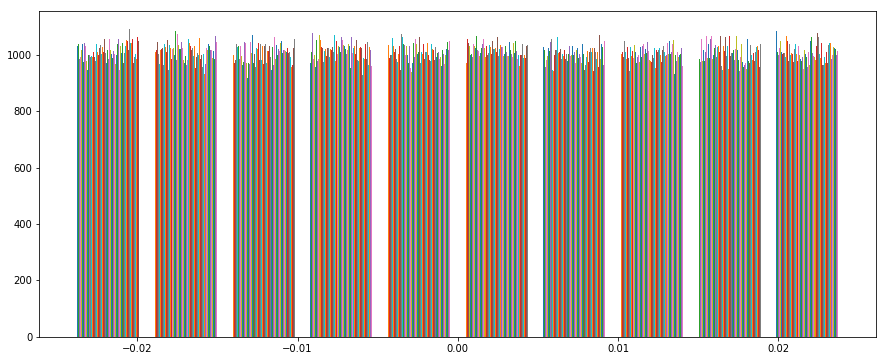

In [231]:
plotWeights(model3e_relu_untrained.get_weights()[0])

Train on 45000 samples, validate on 5000 samples
Epoch 1/15
45000/45000 [==============================] - 5s 113us/step - loss: 0.6941 - acc: 0.5036 - val_loss: 0.6931 - val_acc: 0.5066


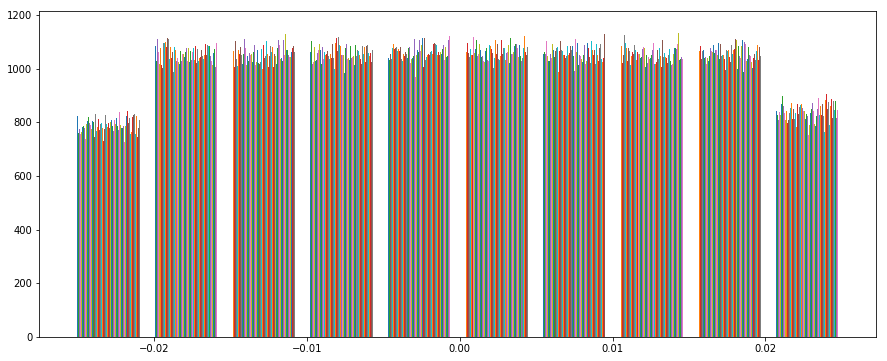

Epoch 2/15
45000/45000 [==============================] - 4s 84us/step - loss: 0.6925 - acc: 0.5183 - val_loss: 0.6927 - val_acc: 0.5112


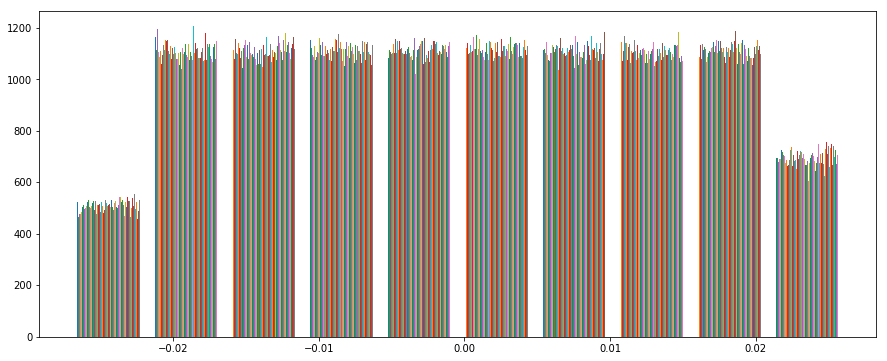

Epoch 3/15
45000/45000 [==============================] - 3s 77us/step - loss: 0.6912 - acc: 0.5294 - val_loss: 0.6914 - val_acc: 0.5172


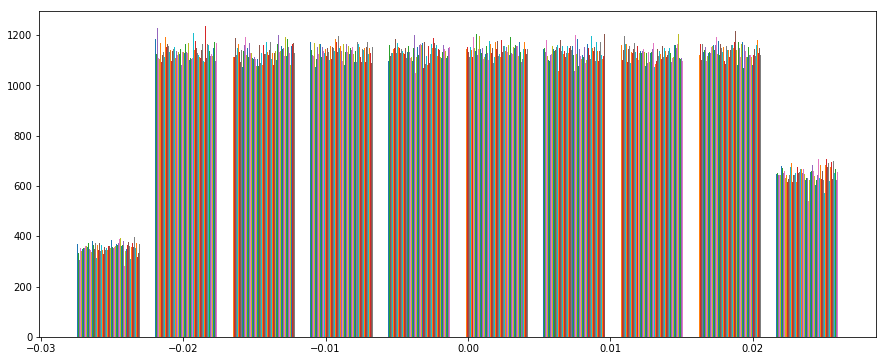

Epoch 4/15
45000/45000 [==============================] - 3s 78us/step - loss: 0.6901 - acc: 0.5356 - val_loss: 0.6908 - val_acc: 0.5222


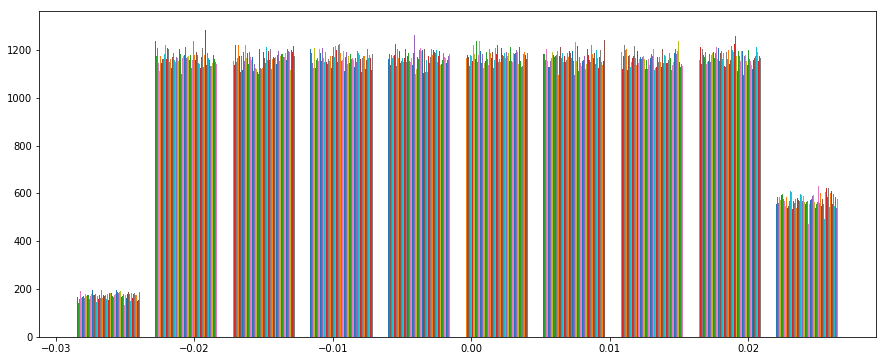

Epoch 5/15
45000/45000 [==============================] - 4s 80us/step - loss: 0.6892 - acc: 0.5428 - val_loss: 0.6907 - val_acc: 0.5322


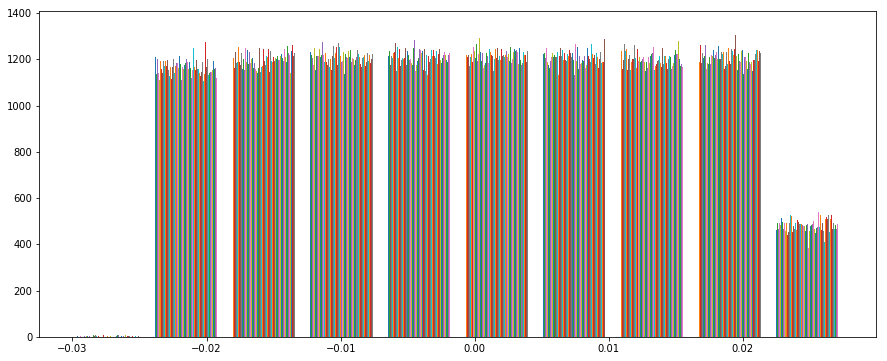

Epoch 6/15
45000/45000 [==============================] - 3s 76us/step - loss: 0.6882 - acc: 0.5498 - val_loss: 0.6902 - val_acc: 0.5376


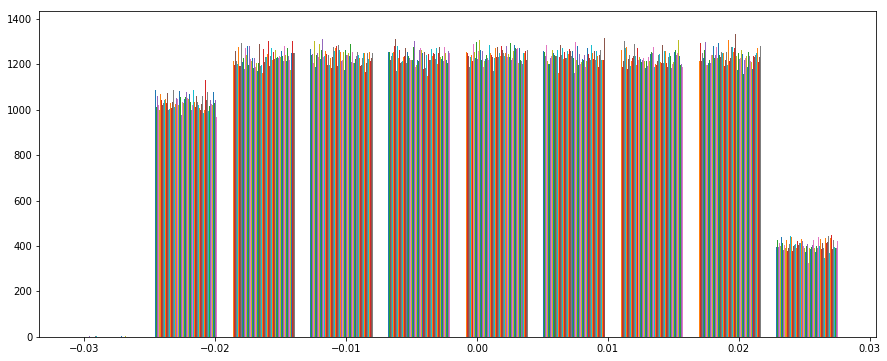

Epoch 7/15
45000/45000 [==============================] - 4s 83us/step - loss: 0.6872 - acc: 0.5556 - val_loss: 0.6894 - val_acc: 0.5306


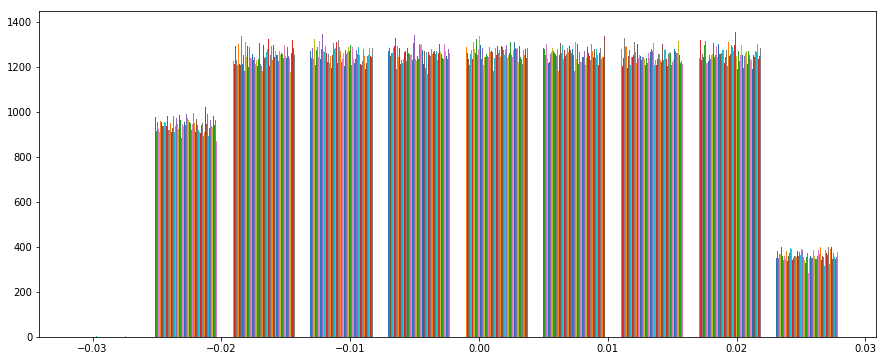

Epoch 8/15
45000/45000 [==============================] - 3s 76us/step - loss: 0.6864 - acc: 0.5595 - val_loss: 0.6894 - val_acc: 0.5480


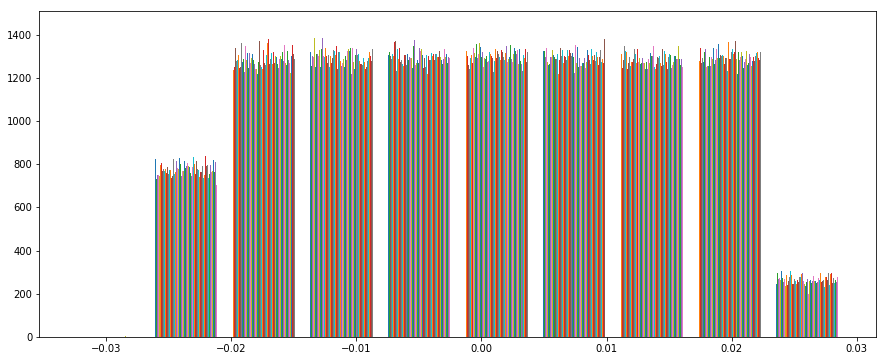

Epoch 9/15
45000/45000 [==============================] - 3s 77us/step - loss: 0.6854 - acc: 0.5634 - val_loss: 0.6887 - val_acc: 0.5510


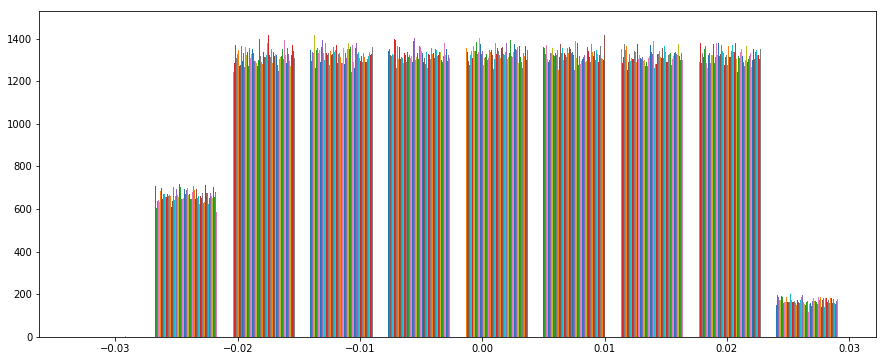

Epoch 10/15
45000/45000 [==============================] - 4s 79us/step - loss: 0.6845 - acc: 0.5686 - val_loss: 0.6880 - val_acc: 0.5516


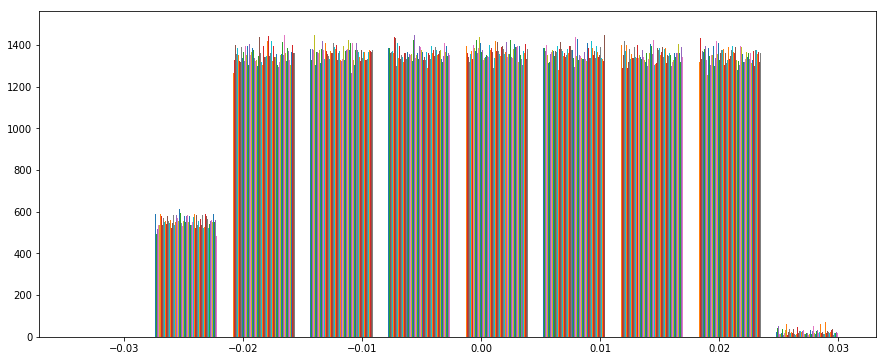

Epoch 11/15
45000/45000 [==============================] - 3s 76us/step - loss: 0.6836 - acc: 0.5743 - val_loss: 0.6874 - val_acc: 0.5468


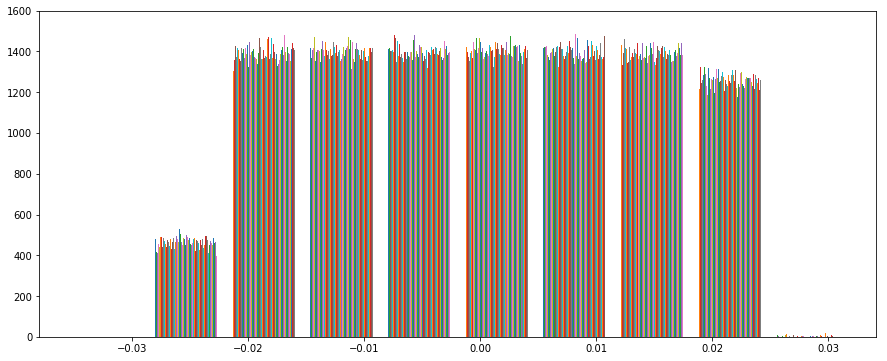

Epoch 12/15
45000/45000 [==============================] - 4s 79us/step - loss: 0.6827 - acc: 0.5742 - val_loss: 0.6871 - val_acc: 0.5524


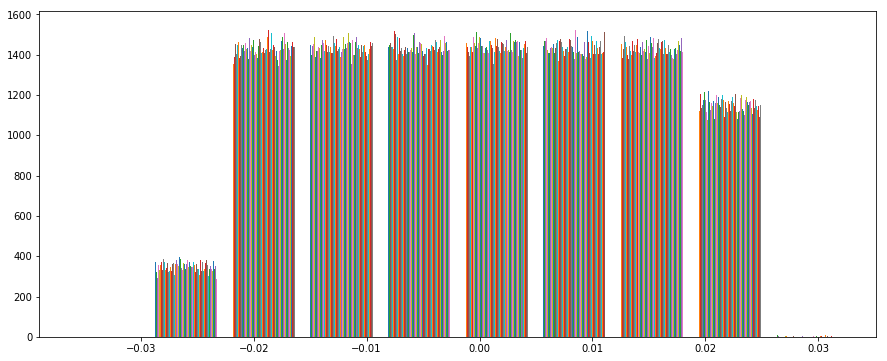

Epoch 13/15
45000/45000 [==============================] - 3s 78us/step - loss: 0.6818 - acc: 0.5787 - val_loss: 0.6868 - val_acc: 0.5574


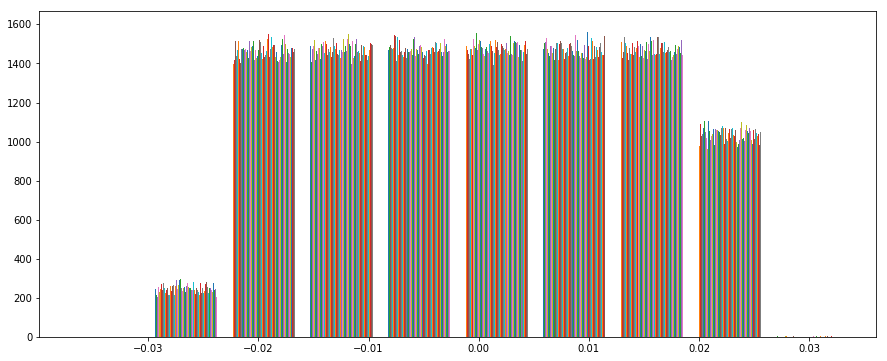

Epoch 14/15
45000/45000 [==============================] - 4s 79us/step - loss: 0.6808 - acc: 0.5803 - val_loss: 0.6860 - val_acc: 0.5532


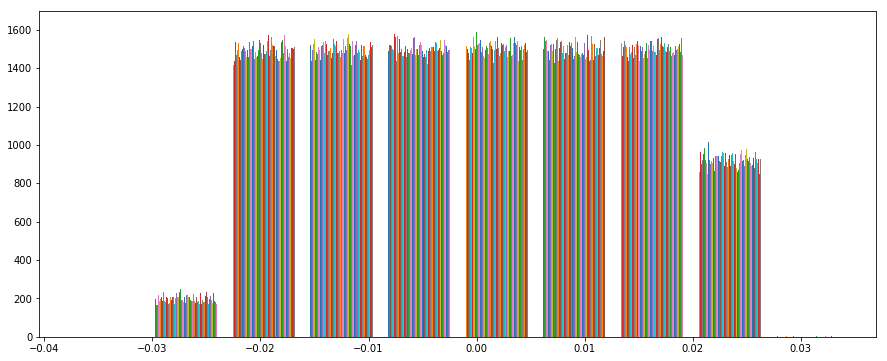

Epoch 15/15
45000/45000 [==============================] - 4s 81us/step - loss: 0.6799 - acc: 0.5838 - val_loss: 0.6860 - val_acc: 0.5580


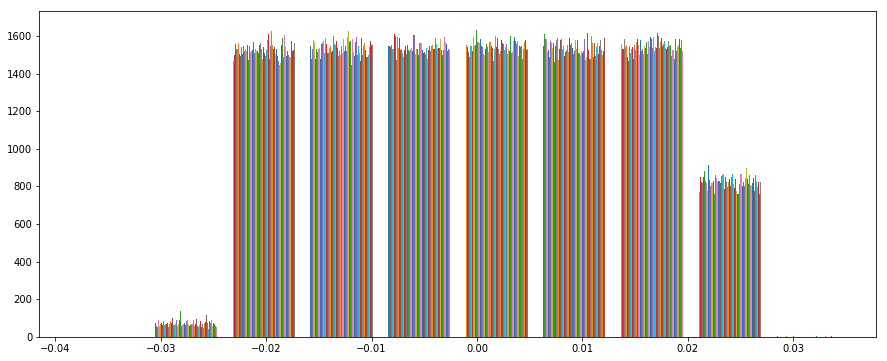

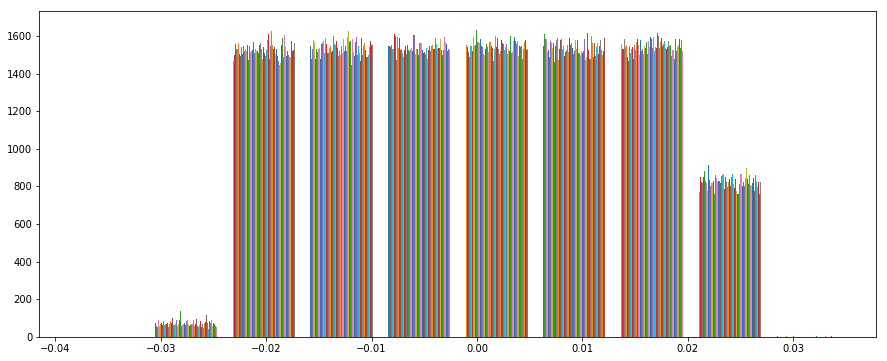

In [232]:
units=128
model3e_relu_trained = Sequential()
model3e_relu_trained.add(Dense(units=units, activation='relu', input_dim=x_tr.shape[1]))
model3e_relu_trained.add(Dense(1,activation='sigmoid'))
model3e_relu_trained.compile(SGD(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])

show_weights = LambdaCallback(on_epoch_end=lambda batch, 
                              logs: plotWeights(model3e_relu_trained.get_weights()[0]))


model3e_relu_trained.fit(x_tr,y_tr, epochs=15, validation_data=(x_val,y_val),
                        callbacks=[show_weights])
plt.figure(figsize=(15,6))
plt.hist(model3e_relu_trained.get_weights()[0])
plt.show()

#### 3.f Extreme learning Machine **(Opcional)**
En esta pregunta implementaremos una _extreme learning machine_ o ELM. Este modelo puede asimilarse a una red neuronal como la entrenada anteriormente pero donde los pesos que conectan al _input_ y la capa oculta no son entrenables. Podemos realizar esto manualmente en algunos casos o utilizando igualmente keras como muestra el código. 
Entrene una ELM y compare los tiempos de entrenamiento y desempeños obtenidos para redes con el mismo número de neuronas. Compare tambien el número de parámetros entrenables respecto redes densas del mismo tamaño. 

Pruebe un par de tamaños de red distintos, considerando la cantidad de parámetros libres de los modelos en cuestión y comente. 

> Compare tambien el número de parámetros entrenables respecto redes densas del mismo tamaño. 

Claramente la cantidad de parametros entrenables son considerablemente menor, ya que solo los interesa la capa de salida, tenemos $512 + 1$ pesos a entrenar (los pesos asociados a cada neurona + el bias).

> Pruebe un par de tamaños de red distintos, considerando la cantidad de parámetros libres de los modelos en cuestión y comente. 

Si bien probamos una sola red, el problema que nosotros consideramos va mas alla del tamaño de la red, sino mas bien de la representación. 
En este caso entrenando la red por 15 epochs, podemos observar que es muy poca ganancia a un clasificador por azar. 


In [237]:
model3f_extreme = Sequential()
model3f_extreme.add(Dense(512, activation='relu',trainable=False))
model3f_extreme.add(Dense(1,activation='sigmoid'))
model3f_extreme.compile(SGD(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])
history3f_extreme=model3f_extreme.fit(x_tr,y_tr, epochs=15, validation_data=(x_val,y_val))

Train on 45000 samples, validate on 5000 samples
Epoch 1/15
45000/45000 [==============================] - 4s 93us/step - loss: 0.6947 - acc: 0.4960 - val_loss: 0.6934 - val_acc: 0.5012
Epoch 2/15
45000/45000 [==============================] - 3s 71us/step - loss: 0.6943 - acc: 0.4986 - val_loss: 0.6931 - val_acc: 0.5130
Epoch 3/15
45000/45000 [==============================] - 5s 102us/step - loss: 0.6942 - acc: 0.4986 - val_loss: 0.6930 - val_acc: 0.5172
Epoch 4/15
45000/45000 [==============================] - 4s 96us/step - loss: 0.6941 - acc: 0.4998 - val_loss: 0.6929 - val_acc: 0.5222
Epoch 5/15
45000/45000 [==============================] - 4s 78us/step - loss: 0.6940 - acc: 0.5023 - val_loss: 0.6928 - val_acc: 0.5222
Epoch 6/15
45000/45000 [==============================] - 5s 109us/step - loss: 0.6939 - acc: 0.5021 - val_loss: 0.6927 - val_acc: 0.5238
Epoch 7/15
45000/45000 [==============================] - 5s 108us/step - loss: 0.6938 - acc: 0.5029 - val_loss: 0.6926 - val_a

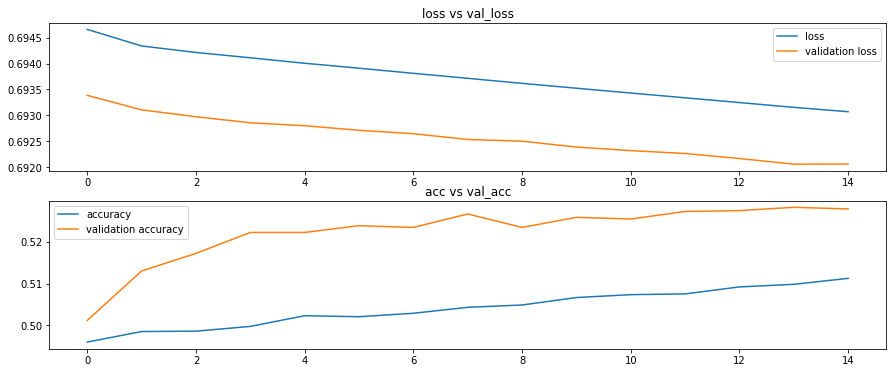

In [238]:
showValAcc(history3f_extreme)

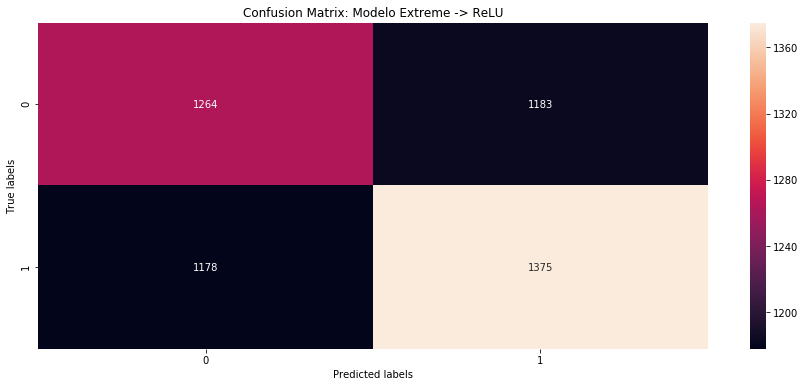

              precision    recall  f1-score   support

           0       0.52      0.52      0.52      2447
           1       0.54      0.54      0.54      2553

   micro avg       0.53      0.53      0.53      5000
   macro avg       0.53      0.53      0.53      5000
weighted avg       0.53      0.53      0.53      5000



In [240]:
y_pred=model3f_extreme.predict(x_val)
y_pred_binary = np.where(y_pred>0.5, 1,0)
plotCM(y_val, y_pred_binary, 'Modelo Extreme -> ReLU')
print(classification_report(y_val, y_pred_binary))

#### 3.g Autoencoders  **(Opcional)**
Otra aproximación muy ingeniosa para mejorar el desempeño de algunos modelos es el uso de _autoenconders_. Comente brevemente sobre qué realizar un _autoencoder_ y sobre por qué no necesita conocer el target para entrenarse.

**Comentarios**:
La gracia de los autoencoders corresponden a que es una arquitectura de red neuronal la cual aprovecha las dos partes: Encoder y Decoder. La gracia de esto es que a diferencia de utilizar el encoder y el decoder para generar tareas de modelar secuencias con un input distinto al output, aqui aprovechamos esta arquitectura para modelar una red que dado el input, se encarga de reconstruir el input pasando por una (o varias) capas ocultas. Formalmente:

$$\Phi: X \rightarrow F$$
$$\Psi: F \rightarrow X$$
$$\Phi,\Psi = \underset{\Phi,\Psi}{argmin}||X - (\Psi \circ \Phi)X||^2$$

La idea entonces, es tomar con el encoder los datos origininales y llevarlos a una menor dimensionalidad. Luego ocupamos esta representación de menor dimensionalidad como entrada para el decoder y la red se entrena de tal manera, que esta representación de baja dimensionalidad sea representativa de los datos originales, cosa que se pueda reconstruir utilizando el decoder (o llegando lo mas cerca posible a la representación original). A modo gráfico se puede ver a continuación:
![](autoencoder.png)

Finalmente, con el autoencoder entrenado, podemos utilizar solo el encoder como una nueva entrada para otras arquitecturas de redes neuronales. Por lo que uno puede entrenar autoencoders con una muchisima cantidad de datos, obtener buenas representaciones en el espacio latente (y que sean robustas al ruido), y finalmente servir esta forma de representación como input a nuevas redes sin realizar entrenamiento sobre el encoder. 

>Esta característica de los _autoencoders_ han permitido mejorar drásticamente muchas aplicaciones reales donde se tienen enormes cantidades de datos sin _target_ y menos datos ya etiquetados (por ejemplo, en reconocimiento de imagenes google tiene acceso a una cantidad en la práctica ilimitada de fotos de sus usuarios pero muy pocas fotos "etiquetadas" en comparación), aprendiendo representaciones relevantes de los datos y luego transfiriendo ese conocimiento. En esta pregunta utilizaremos un autoencoder para tratar de mejorar el desempeño de la red neuronal densa. 

>Para esto primero entrenaremos una red neuronal densa que tiene como _input_ y _target_ nuestros `x_tr`. Una vez entrenada esa red, extraeremos sus pesos de la capa escondida para obtener nuestra capa _encoder_ y nuestra capa _decoder_. Finalmente, utilizaremos nuestra capa de _encoding_ como la primera capa de un nuevo modelo (más pequeño), el cual luego entrenaremos sin modificar los pesos de la capa _encoding_.

>Note que este procedimiento también puede hacerse como un preprocesamiento de los datos, sin embargo les propongo esta manera pues pone en evidencia el proceso de _transfer learning_ que comentabamos anteriormente. 

In [13]:
model3g_autoencoder = Sequential()
model3g_autoencoder.add(Dense(128, activation='relu')) # you can change the number of units
model3g_autoencoder.add(Dense(x_tr.shape[1]))
model3g_autoencoder.compile(SGD(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])
model3g_autoencoder.fit(x_tr,x_tr, epochs=15, validation_data=(x_val,x_val))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 45000 samples, validate on 5000 samples
Epoch 1/15
45000/45000 [==============================] - 9s 193us/step - loss: 0.0753 - acc: 0.9901 - val_loss: 0.0650 - val_acc: 0.9901
Epoch 2/15
45000/45000 [==============================] - 6s 124us/step - loss: 0.0626 - acc: 0.9901 - val_loss: 0.0612 - val_acc: 0.9901
Epoch 3/15
45000/45000 [==============================] - 6s 132us/step - loss: 0.0603 - acc: 0.9901 - val_loss: 0.0597 - val_acc: 0.9901
Epoch 4/15
45000/45000 [==============================] - 5s 117us/step - loss: 0.0590 - acc: 0.9901 - val_loss: 0.0585 - val_acc: 0.9901
Epoch 5/15
45000/45000 [==============================] - 6s 130us/step - loss: 0.0580 - acc: 0.9901 - val_loss: 0.0576 - val_acc: 0.9901
Epoch 6/15
45000/45000 [==============================] - 5s 122us/step - loss: 0.0571 - acc: 0.9901 - val_loss: 0.0567 - val_acc: 0.9901
Epo

In [14]:
encoder3g = model3g_autoencoder.layers[0]
decoder3g = model3g_autoencoder.layers[1]

In [15]:
#create the new model
model3g = Sequential()
model3g.add(encoder3g)
model3g.layers[0].trainable = False 
model3g.add(Dense(128, activation='relu')) # you can change the number of units
model3g.add(Dense(1, activation='sigmoid'))
model3g.compile(SGD(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])
model3g.fit(x_tr,y_tr, epochs=15, validation_data=(x_val,y_val))
# we dont want to train the encoder
# add the hidden and output layers

# compile and fit

Train on 45000 samples, validate on 5000 samples
Epoch 1/15
45000/45000 [==============================] - 2s 52us/step - loss: 0.6934 - acc: 0.4972 - val_loss: 0.6932 - val_acc: 0.4992
Epoch 2/15
45000/45000 [==============================] - 2s 51us/step - loss: 0.6933 - acc: 0.5001 - val_loss: 0.6931 - val_acc: 0.5040
Epoch 3/15
45000/45000 [==============================] - 2s 50us/step - loss: 0.6932 - acc: 0.5006 - val_loss: 0.6930 - val_acc: 0.5098
Epoch 4/15
45000/45000 [==============================] - 3s 72us/step - loss: 0.6931 - acc: 0.5033 - val_loss: 0.6929 - val_acc: 0.5120
Epoch 5/15
45000/45000 [==============================] - 3s 65us/step - loss: 0.6930 - acc: 0.5049 - val_loss: 0.6929 - val_acc: 0.5128
Epoch 6/15
45000/45000 [==============================] - 2s 50us/step - loss: 0.6929 - acc: 0.5057 - val_loss: 0.6928 - val_acc: 0.5092
Epoch 7/15
45000/45000 [==============================] - 3s 69us/step - loss: 0.6929 - acc: 0.5073 - val_loss: 0.6928 - val_acc:

In [16]:
model3g.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               1292928   
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 1,309,569
Trainable params: 16,641
Non-trainable params: 1,292,928
_________________________________________________________________


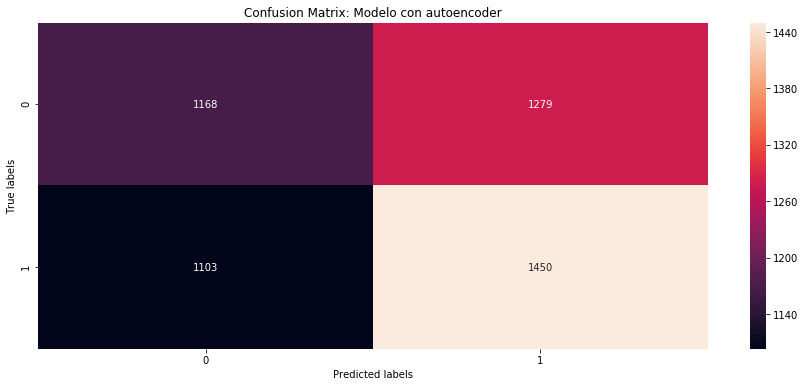

              precision    recall  f1-score   support

           0       0.51      0.48      0.50      2447
           1       0.53      0.57      0.55      2553

   micro avg       0.52      0.52      0.52      5000
   macro avg       0.52      0.52      0.52      5000
weighted avg       0.52      0.52      0.52      5000



In [17]:
y_pred=model3g.predict(x_val)
y_pred_binary = np.where(y_pred>0.5, 1,0)
plotCM(y_val, y_pred_binary, 'Modelo con autoencoder')
print(classification_report(y_val, y_pred_binary))

**Comentarios**

El rendimiento del autoencoder como metodo de entrenamiento no beneficia a la red, quedando con un rendimiento un poco mejor que el clasificador por azar, sesgandose levemente hacia la clase positiva. 

Lamentablemente este modelo puede que falten datos para obtener una buena representación latente (son solo 50000 muestras de 100 palabras cada una), o mas epochs de entrenamiento. Si uno mira las tecnicas de la vanguardia solo en terminos de cuantos datos utilizan, son por el orden de 18 Millones de muestras con un largo de 512 tokens (vease [BERT](https://github.com/google-research/bert)).

#### 3.h Árbol

Utilizemos ahora un arbol de clasificación para tratar de resolver el problema. Para este modelo es recomendable usar los datos originales (antes de utilizar la función `to_categorical`), si bien el modelo podrá ajustarse y encontrará desempeños parecidos, el tiempo de cómputo será mucho mayor con los datos categóricos.

Luego de entrenar el árbol, calcule su _accuracy_ y compare el desempeño con las redes entrenadas anteriormente. 

In [43]:
tree3h = DecisionTreeClassifier(max_depth=45) #or another depth 
tree3h.fit(x_tr_o,y_tr)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=45,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

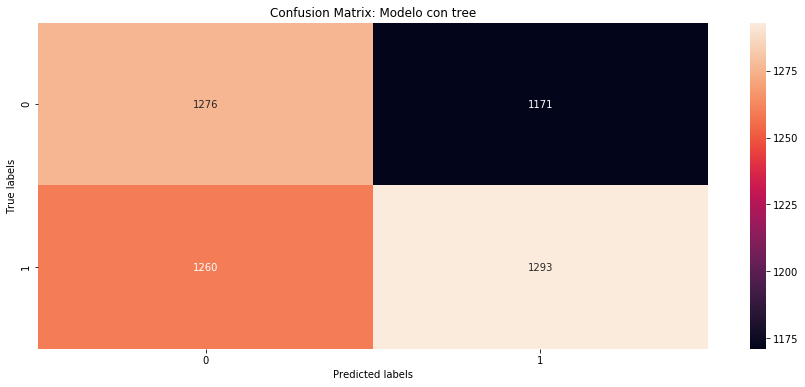

              precision    recall  f1-score   support

           0       0.51      0.53      0.52      2447
           1       0.53      0.51      0.52      2553

   micro avg       0.52      0.52      0.52      5000
   macro avg       0.52      0.52      0.52      5000
weighted avg       0.52      0.52      0.52      5000



In [44]:
y_pred=tree3h.predict(x_val_o)
plotCM(y_val, y_pred, 'Modelo con tree')
print(classification_report(y_val, y_pred_binary))

**Comentarios**

Para el arbol de decisión, el rendimiento es un poco mejor que un clasificador por azar. Esto puede ser debido a que la representación de los textos no sea la correcta. Historicamente para los modelos clasicos de Machine Learning la representación utilizada corresponde a vectores que pierden información de la secuencia. 

Estas representaciones pueden ser la binarización de si se encuentra una palabra o no en el texto, el numero de veces de la ocurrencia de la palabra (`CountVectorizer`), representaciones en las cuales los terminos tienen un penalizador respecto a cuantas veces ocurren en los documentos (representación `TF-IDF`: Term Frequency - Inverse Document Frequency),etc.



#### 3.i Bagging **(Opcional)**

Crearemos ahora un ensamblado utilizando la técnica de _Bagging_, ensamblando las predicciones de distintos árboles para predecir el resultado. 

Explique brevemente el procedimiento realizado por _Bagging_, en particular por qué los distintos arboles no se entrenan idénticamente y el significado de los parámetros que aparecen en el código. 

**Comentarios**

Bagging divide el set de entrenamiento en distintos subsets de datos, usando selección aleatoria uniforme con reincorporación de los datos (con reemplazo). Es decir, algunos de los datos pueden repetirse en cada una de las submuestras generadas. Este tipo de técnicas es usada para mejorar la clasificación del training set. En caso de la clasificación, el resultado final suele obtenerse por votación.

Bagging también es apto para disminuir el overfitting de los modelos, ya que cada modelo aporta desde su aprendizaje en el set que le ha tocado mirar.

Parametros del código:

- Base estimator: el algoritmo, o learner base que será utilizado en el entrenamiento de cada conjunto.
- n_estimators: la cantidad de estimadores base en el ensamblaje.
- max_samples: el % de datos maximo que tendra cada submuestra, respecto al total general.
- max_features: el % máximo de caracteristicas o variables que considerará cada estimador base.


In [51]:
bag3i = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                        n_estimators=100,
                        max_samples=0.5,
                        max_features=0.7
                       )

In [52]:
model3i=bag.fit(x_tr_o, y_tr)

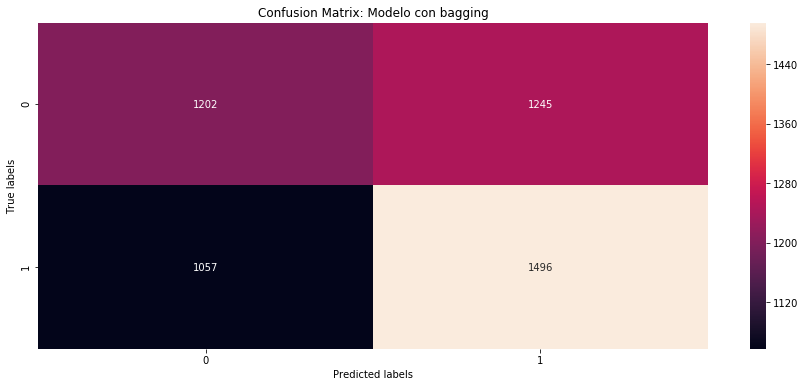

              precision    recall  f1-score   support

           0       0.51      0.53      0.52      2447
           1       0.53      0.51      0.52      2553

   micro avg       0.52      0.52      0.52      5000
   macro avg       0.52      0.52      0.52      5000
weighted avg       0.52      0.52      0.52      5000



In [59]:
y_pred=model3i.predict(x_val_o)
plotCM(y_val, y_pred, 'Modelo con bagging')
print(classification_report(y_val, y_pred_binary))

**Comentarios:**
El rendimiento es similar al modelo simple de arbol de decisión, pero con una mejora para la clase positiva. De nuevo, esto puede ser debido a la representación de los textos, pero la mejor de rendimiento puede deberse al potencial de bagging al introducir la capacidad del modelo ensemble.


#### 3.j AdaBoost
_Adaptative Boosting_ o AdaBoost es otro meta-algoritmo que crea ensamblados a partir de modelos más simple. Entrene un modelo de AdaBoost con estimado base un árbol de baja profundidad (menor a 20) y un límite de estimadores (`n_estimators`) de a lo menos 50. 

Calcule su _accuracy_ y comparelo con los demás métodos. 

In [55]:
ada3j = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=15),
                        n_estimators=100
                       )

In [56]:
model3j=ada3j.fit(x_tr_o, y_tr)

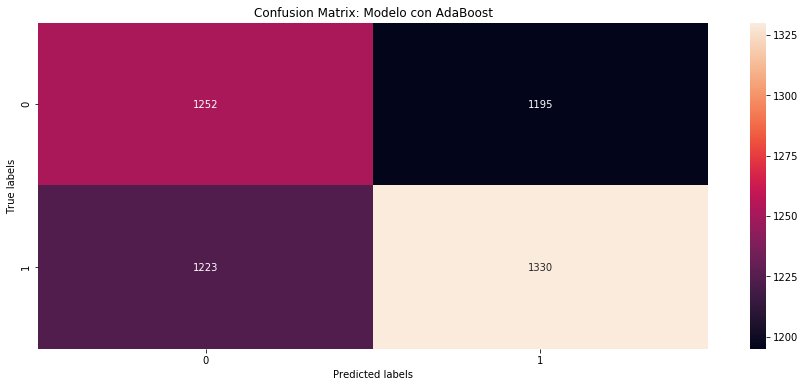

              precision    recall  f1-score   support

           0       0.51      0.51      0.51      2447
           1       0.53      0.52      0.52      2553

   micro avg       0.52      0.52      0.52      5000
   macro avg       0.52      0.52      0.52      5000
weighted avg       0.52      0.52      0.52      5000



In [60]:
y_pred=model3j.predict(x_val_o)
plotCM(y_val, y_pred, 'Modelo con AdaBoost')
print(classification_report(y_val, y_pred))

>Calcule su _accuracy_ y comparelo con los demás métodos. 

$Acc = \frac{1252 + 1330}{1252 + 1195 + 1223 + 1330} = 0.5164$

Finalmente, podemos ver para AdaBoost con 100 arboles, el rendimiento un poco mejor que un clasificador por azar, de la misma manera que la mayoria de los modelos clasicos, a excepcion de la regresion lineal.
